# Correlation lengths - non_triv proj rep

Created 04/12/2025

Objectives:
* Found some weird results in [this notebook](correlation_lengths.ipynb) showing that the non trivial proj rep states had a lower correlation length! Replicate here in a clean envirionment to make sure.

# Package imports

In [441]:
import sys
sys.path.append('../')

In [442]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os
import pickle

In [443]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [444]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import (
    to_npc_array,
    get_right_identity_environment,
    get_right_identity_environment_from_tp_tensor,
    multiply_stacked_unitaries_against_mps,
    inner_product_b_tensors,
    get_npc_identity_operator,
    get_transfer_matrix_from_unitary,
    multiply_transfer_matrices
)

from SPTOptimization.Optimizers.MPSBrickSolver import(
    MPSBrickSolver
)

In [445]:
from functools import reduce

# Load data

In [464]:
DATA_DIR_1 = r"../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [447]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [7]:
loaded_data_triv_proj_rep = dict()
energies_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_1))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_1, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_triv_proj_rep[data_info]=data['wavefunction']
        energies_triv_proj_rep[data_info]=data['energy']

In [465]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

# Definitons

In [449]:
MAX_VIRTUAL_BOND_DIM = 30
MAX_INTERMEDIATE_VIRTUAL_BOND_DIM = 2*MAX_VIRTUAL_BOND_DIM
# MPO bond dim?
MAX_MPO_BOND_DIM = 50

SVD_CUTOFF = 1e-3

Define bosonic symmetries. Label by the group element added.

In [450]:
np_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_01 = np.array([
    [0, 1, 0, 0],
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

np_11 = np.array([
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0],
    [1, 0, 0, 0]
])

In [451]:
bosonic_np_symmetries = [
    np_00,
    np_01,
    np_10,
    np_11
]

In [452]:
bosonic_npc_symmetries = [
    to_npc_array(X) for X in bosonic_np_symmetries
]

In [453]:
npc_00 = to_npc_array(np_00)
npc_01 = to_npc_array(np_01)
npc_10 = to_npc_array(np_10)
npc_11 = to_npc_array(np_11)

Define "fermionic symmetries". Just identity and JW string.

In [454]:
np_I = np.array([
    [1, 0],
    [0, 1]
])

np_JW = np.array([
    [1, 0],
    [0, -1]
])

In [455]:
fermionic_np_symmetries = [np_I, np_JW]

In [456]:
fermionic_npc_symmetries = [
    to_npc_array(X) for X in fermionic_np_symmetries
]

In [457]:
npc_JW = fermionic_npc_symmetries[1]

In [458]:
symmetry_actions = [
    [[b, f] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [459]:
shifted_symmetry_actions = [
    [[f, b] for b in bosonic_np_symmetries]
    for f in fermionic_np_symmetries
]

In [460]:
cases_triv_proj_rep = dict()

for k, psi in loaded_data_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_triv_proj_rep[(k, i, j)] = case

In [461]:
for c in cases_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [22]:
cases_non_triv_proj_rep = dict()

for k, psi in loaded_data_non_triv_proj_rep.items():

    for i, l in enumerate(symmetry_actions):

        for j, s in enumerate(l):
            case = SymmetryActionWithBoundaryUnitaries(
                psi,
                s*40,
                left_symmetry_index=60,
                left_boundary_unitaries=[np_I, np_00]*1,
                right_boundary_unitaries=[np_00, np_I]*1
            )

            cases_non_triv_proj_rep[(k, i, j)] = case

In [23]:
for c in cases_non_triv_proj_rep.values():
    c.compute_svd_approximate_expectation()

In [24]:
left_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=1
)

In [25]:
right_trivial_leg_charge = tenpy.linalg.charges.LegCharge(
    tenpy.linalg.charges.ChargeInfo([], []),
    [0,1],
    [[]],
    qconj=-1
)

# Analysis

## Fermion occupation

In [16]:
interpolation_values = sorted(list(energies_triv_proj_rep.keys()))

In [17]:
def get_two_point_fn_expectation(psi, distance):
    ops = ['N',] + ['Id',]*(2*distance-1) + ['N']

    left_site = (200 - distance)//2

    if (left_site % 2) == 0:
        left_site += 1

    return psi.expectation_value_multi_sites(ops, left_site)

In [18]:
distances = list(range(1, 21))

In [19]:
fermion_occupation_2_point_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_triv_proj_rep[t]
    out = [
        get_two_point_fn_expectation(psi, d)
        for d in distances
    ]
    fermion_occupation_2_point_triv_proj_rep.append(out)

fermion_occupation_2_point_triv_proj_rep = np.array(
    fermion_occupation_2_point_triv_proj_rep
)

In [20]:
fermion_occupation_2_point_triv_proj_rep.shape

(21, 20)

In [22]:
fermion_occupation_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_triv_proj_rep[t]
    out = psi.expectation_value('N', sites=[99,])[0]
    fermion_occupation_triv_proj_rep.append(out)

In [23]:
fermion_occupation_correlation_triv_proj_rep = (
    fermion_occupation_2_point_triv_proj_rep
    - (np.array(fermion_occupation_triv_proj_rep)**2)[:, np.newaxis]
)

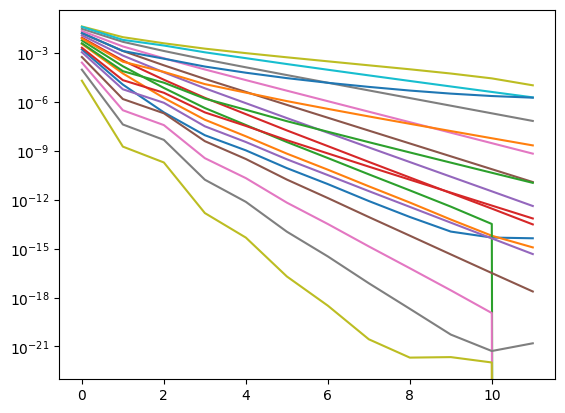

In [24]:
for X in fermion_occupation_correlation_triv_proj_rep[1:-1]:
    plt.plot(X[:12])

plt.yscale('log')

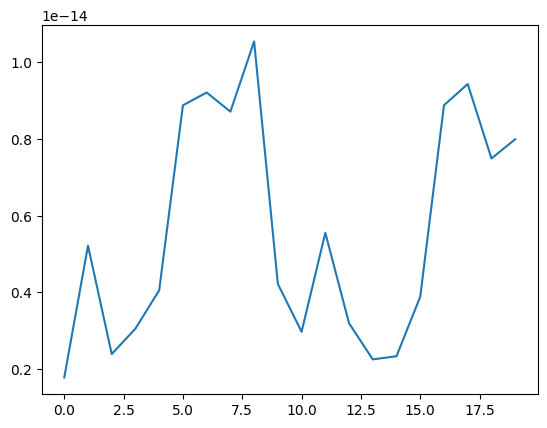

In [25]:
plt.plot(fermion_occupation_correlation_triv_proj_rep[0])

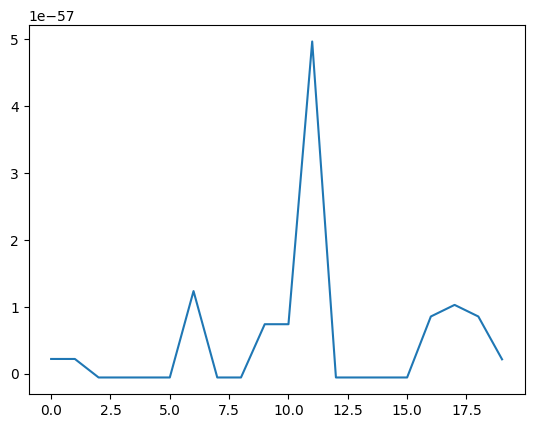

In [26]:
plt.plot(fermion_occupation_correlation_triv_proj_rep[-1])

In [27]:
X = fermion_occupation_correlation_triv_proj_rep

fermion_occupation_correlation_lengths_triv_proj_rep = 2/np.log(X[:,0]/X[:,2])
fermion_occupation_correlation_lengths_triv_proj_rep[0] = 0
fermion_occupation_correlation_lengths_triv_proj_rep[-1] = 0

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/478957739.py:3: RuntimeWarning: invalid value encountered in log
  fermion_occupation_correlation_lengths_triv_proj_rep = 2/np.log(X[:,0]/X[:,2])


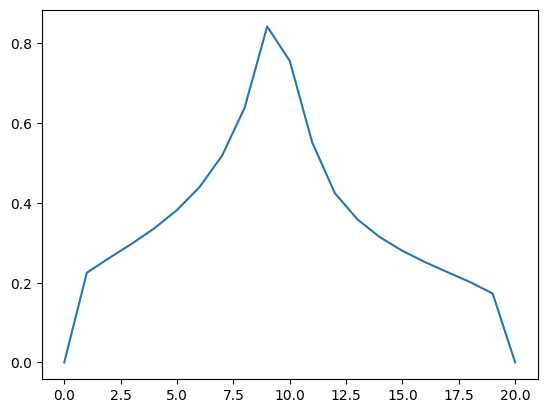

In [28]:
plt.plot(fermion_occupation_correlation_lengths_triv_proj_rep)

Text(0.5, 1.0, 'Correlation length of $\\hat{n}_f$ for $H_{f,1}(t)$')

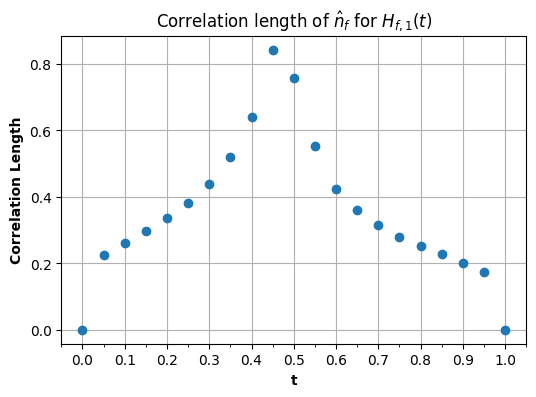

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    interpolation_values,
    fermion_occupation_correlation_lengths_triv_proj_rep,
    'o'
)

ax.grid()

ax.set_xticks(interpolation_values)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#
ax.set_xlabel("t", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.set_title(r"Correlation length of $\hat{n}_f$ for $H_{f,1}(t)$")
#fig.savefig(r'plots/trivial_fermion_phase_n_correlation_lengths.png', dpi=200)

In [30]:
fermion_occupation_2_point_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    out = [
        get_two_point_fn_expectation(psi, d)
        for d in distances
    ]
    fermion_occupation_2_point_non_triv_proj_rep.append(out)

fermion_occupation_2_point_non_triv_proj_rep = np.array(
    fermion_occupation_2_point_non_triv_proj_rep
)

In [32]:
fermion_occupation_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    out = psi.expectation_value('N', sites=[99,])[0]
    fermion_occupation_non_triv_proj_rep.append(out)

In [33]:
fermion_occupation_correlation_non_triv_proj_rep = (
    fermion_occupation_2_point_non_triv_proj_rep
    - (np.array(fermion_occupation_non_triv_proj_rep)**2)[:, np.newaxis]
)

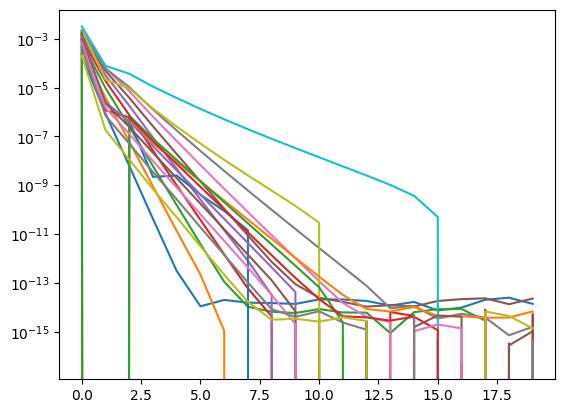

In [34]:
for X in fermion_occupation_correlation_non_triv_proj_rep[1:-1]:
    plt.plot(X)

plt.yscale('log')

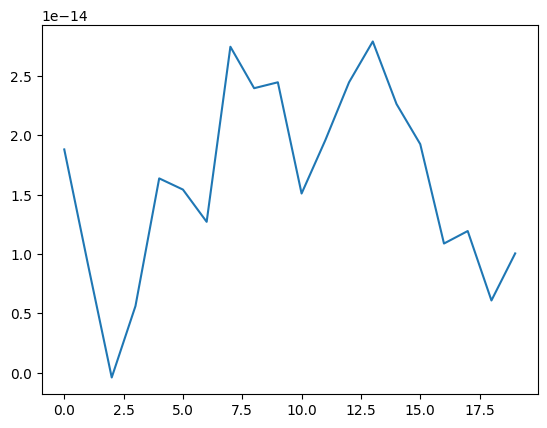

In [35]:
plt.plot(fermion_occupation_correlation_non_triv_proj_rep[0])

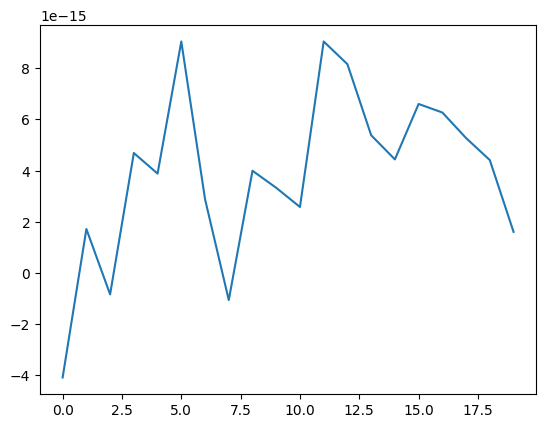

In [36]:
plt.plot(fermion_occupation_correlation_non_triv_proj_rep[-1])

In [37]:
X = fermion_occupation_correlation_non_triv_proj_rep

fermion_occupation_correlation_lengths_non_triv_proj_rep = 2/np.log(X[:,0]/X[:,2])
fermion_occupation_correlation_lengths_non_triv_proj_rep[0] = 0
fermion_occupation_correlation_lengths_non_triv_proj_rep[-1] = 0

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/2608423047.py:3: RuntimeWarning: invalid value encountered in log
  fermion_occupation_correlation_lengths_non_triv_proj_rep = 2/np.log(X[:,0]/X[:,2])


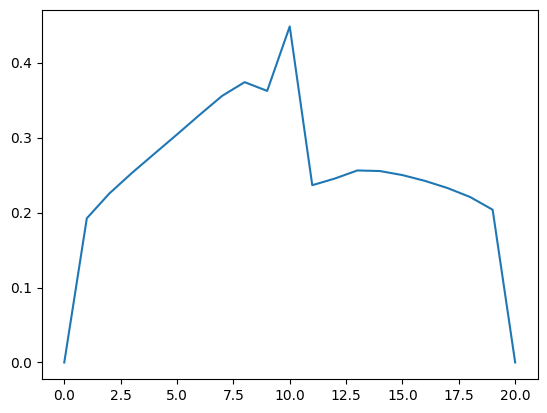

In [38]:
plt.plot(fermion_occupation_correlation_lengths_non_triv_proj_rep)

Text(0.5, 1.0, 'Correlation length in $\\hat{n}_f$')

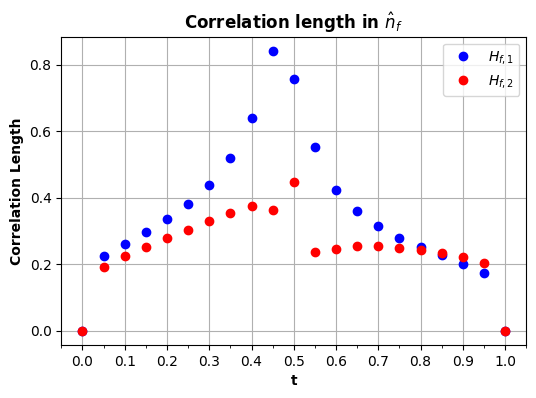

In [40]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    interpolation_values,
    fermion_occupation_correlation_lengths_triv_proj_rep,
    'bo',
    label = '$H_{f,1}$'
)

ax.plot(
    interpolation_values,
    fermion_occupation_correlation_lengths_non_triv_proj_rep,
    'ro',
    label = '$H_{f,2}$'
)

ax.grid()

ax.set_xticks(interpolation_values)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#
ax.set_xlabel("t", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.legend(loc='upper right')

ax.set_title(r"Correlation length in $\hat{n}_f$", fontweight='bold')
#fig.savefig(r'plots/n_correlation_lengths.png', dpi=200)

## Boson operators occupation

In [41]:
def get_two_point_boson_op_expectation(psi, distance, op):
    ops = [op,] + ['Id',]*(2*distance-1) + [op]

    left_site = (200 - distance)//2

    if (left_site % 2) == 1:
        left_site += 1

    return psi.expectation_value_multi_sites(ops, left_site)

In [42]:
distances = list(range(1, 21))

In [44]:
non_trivial_bosonic_npc_symmetries = bosonic_npc_symmetries[1:]

In [45]:
non_trivial_bosonic_npc_symmetries

[<npc.Array shape=(4, 4) labels=['p', 'p*']>,
 <npc.Array shape=(4, 4) labels=['p', 'p*']>,
 <npc.Array shape=(4, 4) labels=['p', 'p*']>]

In [46]:
boosn_occupation_2_point_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_triv_proj_rep[t]
    boosn_occupation_2_point_triv_proj_rep.append(list())
    for op in non_trivial_bosonic_npc_symmetries:
        out = [
            get_two_point_boson_op_expectation(psi, d, op)
            for d in distances
        ]
        boosn_occupation_2_point_triv_proj_rep[-1].append(out)

boosn_occupation_2_point_triv_proj_rep = np.array(
    boosn_occupation_2_point_triv_proj_rep
)

In [47]:
boosn_occupation_2_point_triv_proj_rep.shape

(21, 3, 20)

In [49]:
bosonic_operator_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_operator_triv_proj_rep_exps.append(list())
    psi = loaded_data_triv_proj_rep[t]
    for op in non_trivial_bosonic_npc_symmetries:
        out = psi.expectation_value(op, sites=[100,])[0]
        bosonic_operator_triv_proj_rep_exps[-1].append(out)

bosonic_operator_triv_proj_rep_exps = np.array(bosonic_operator_triv_proj_rep_exps)

In [50]:
boson_occupation_correlation_triv_proj_rep = (
    boosn_occupation_2_point_triv_proj_rep
    - (np.array(bosonic_operator_triv_proj_rep_exps)**2)[..., np.newaxis]
)

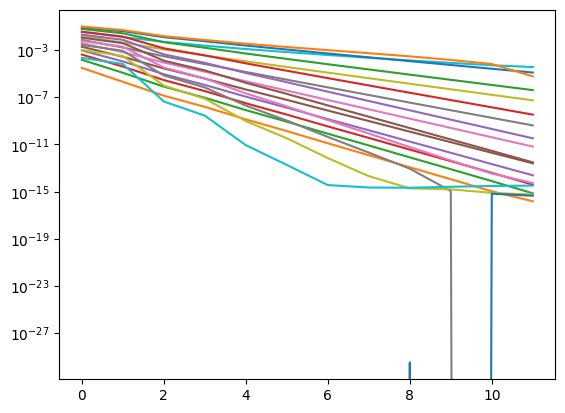

In [51]:
for X in boson_occupation_correlation_triv_proj_rep[:, 0, :]:
    plt.plot(X[:12])

plt.yscale('log')

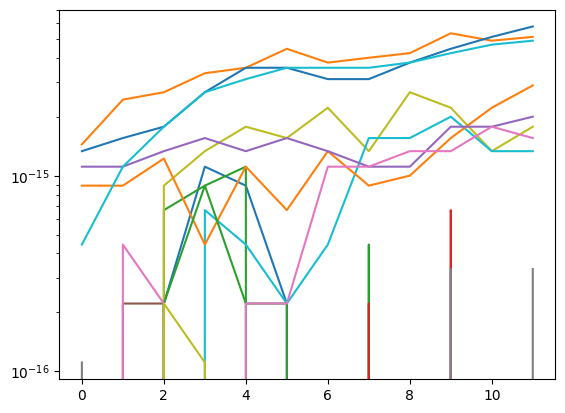

In [52]:
for X in boson_occupation_correlation_triv_proj_rep[:, 1, :]:
    plt.plot(X[:12])

plt.yscale('log')

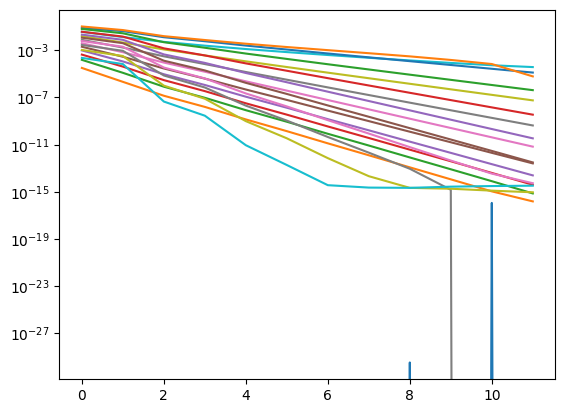

In [53]:
for X in boson_occupation_correlation_triv_proj_rep[:, 2, :]:
    plt.plot(X[:12])

plt.yscale('log')

In [54]:
np.max(boson_occupation_correlation_triv_proj_rep[[0, -1]])

1.3322676295501878e-15

In [55]:
np.max(boson_occupation_correlation_triv_proj_rep[:, 1])

7.771561172376096e-15

In [56]:
X = boson_occupation_correlation_triv_proj_rep[:, [0, 2], :]

boson_op_correlation_lengths_triv_proj_rep = 6/np.log(X[...,0]/X[...,6])
boson_op_correlation_lengths_triv_proj_rep[0] = 0
boson_op_correlation_lengths_triv_proj_rep[-1] = 0

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/3207143794.py:3: RuntimeWarning: divide by zero encountered in log
  boson_op_correlation_lengths_triv_proj_rep = 6/np.log(X[...,0]/X[...,6])


In [57]:
boson_op_correlation_lengths_triv_proj_rep.shape

(21, 2)

Exactly the same... suspect.

In [58]:
X = boson_op_correlation_lengths_triv_proj_rep

np.max(np.abs(X[:, 0] - X[:, 1]))

6.425907650597917e-06

Text(0, 0.5, 'Correlation Length')

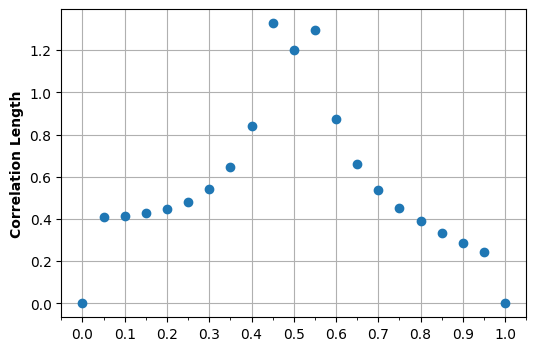

In [59]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    interpolation_values,
    boson_op_correlation_lengths_triv_proj_rep[:, 0],
    'o'
)

ax.grid()

ax.set_xticks(interpolation_values)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#
ax.set_xlabel("", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

#ax.set_title("Correlation length in the ZXZ model as a function of B", fontweight='bold')

The correlation is very small, which makes some of these plots misleading.

In [60]:
boosn_occupation_2_point_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    boosn_occupation_2_point_non_triv_proj_rep.append(list())
    for op in non_trivial_bosonic_npc_symmetries:
        out = [
            get_two_point_boson_op_expectation(psi, d, op)
            for d in distances
        ]
        boosn_occupation_2_point_non_triv_proj_rep[-1].append(out)

boosn_occupation_2_point_non_triv_proj_rep = np.array(
    boosn_occupation_2_point_non_triv_proj_rep
)

In [63]:
bosonic_operator_non_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_operator_non_triv_proj_rep_exps.append(list())
    psi = loaded_data_non_triv_proj_rep[t]
    for op in non_trivial_bosonic_npc_symmetries:
        out = psi.expectation_value(op, sites=[100,])[0]
        bosonic_operator_non_triv_proj_rep_exps[-1].append(out)

bosonic_operator_non_triv_proj_rep_exps = np.array(bosonic_operator_non_triv_proj_rep_exps)

In [64]:
boson_occupation_correlation_non_triv_proj_rep = (
    boosn_occupation_2_point_non_triv_proj_rep
    - (np.array(bosonic_operator_non_triv_proj_rep_exps)**2)[..., np.newaxis]
)

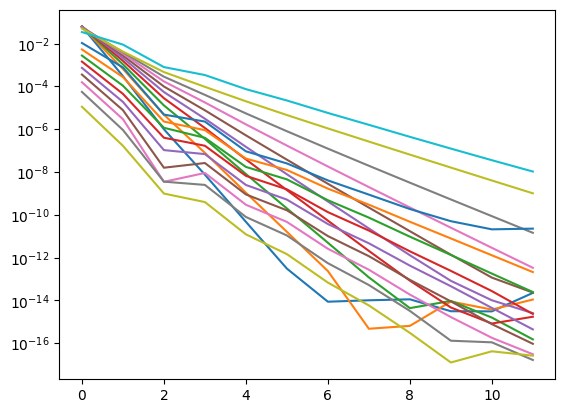

In [65]:
for X in boson_occupation_correlation_non_triv_proj_rep[1:-1, 0, :]:
    plt.plot(np.abs(X[:12]))

plt.yscale('log')

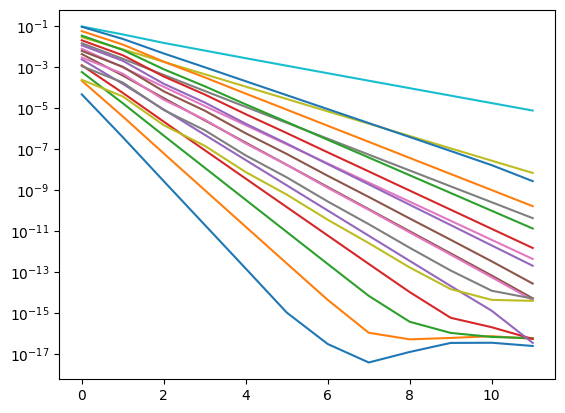

In [66]:
for X in boson_occupation_correlation_non_triv_proj_rep[1:-1, 1, :]:
    plt.plot(np.abs(X[:12]))

plt.yscale('log')

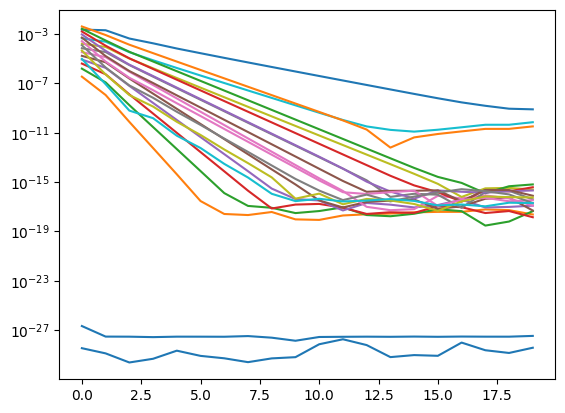

In [67]:
for X in boson_occupation_correlation_non_triv_proj_rep[:, 2, :]:
    plt.plot(np.abs(X))

plt.yscale('log')

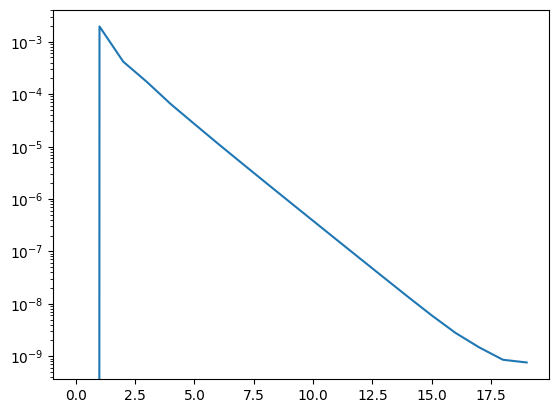

In [68]:
plt.plot(boson_occupation_correlation_non_triv_proj_rep[10, 2, :])

plt.yscale('log')

Crazy behaviour at critical point.

In [69]:
np.max(boson_occupation_correlation_non_triv_proj_rep[[0, -1]])

1.071365218763276e-14

In [70]:
X = boson_occupation_correlation_non_triv_proj_rep

boson_op_correlation_lengths_non_triv_proj_rep = 5/np.log(np.abs(X[...,0]/X[...,5]))
boson_op_correlation_lengths_non_triv_proj_rep[0] = 0
boson_op_correlation_lengths_non_triv_proj_rep[-1] = 0

In [71]:
boson_op_correlation_lengths_non_triv_proj_rep.shape

(21, 3)

In [72]:
markers = ['>', '<', '^']

In [73]:
boson_op_correlation_lengths_triv_proj_rep.shape

(21, 2)

In [74]:
boson_op_correlation_lengths_non_triv_proj_rep.shape

(21, 3)

In [76]:
non_trivial_bosonic_npc_symmetries_labels = ['IX', 'XI', 'XX']

Text(0.5, 1.0, 'Correlation length of boson site operators')

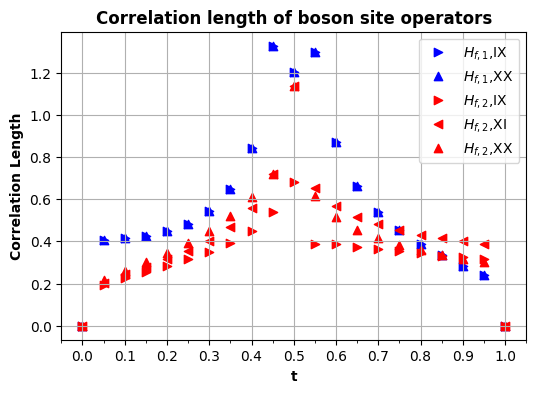

In [77]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(
    interpolation_values,
    boson_op_correlation_lengths_triv_proj_rep[:, 0],
    marker=markers[0],
    color='blue',
    label=r'$H_{f,1}$,' + non_trivial_bosonic_npc_symmetries_labels[0]
)


ax.scatter(
    interpolation_values,
    boson_op_correlation_lengths_triv_proj_rep[:, 1],
    marker=markers[2],
    color='blue',
    label=r'$H_{f,1}$,' + non_trivial_bosonic_npc_symmetries_labels[2]
)

for i, l in enumerate(non_trivial_bosonic_npc_symmetries_labels):
    marker = markers[i]
    ax.scatter(
        interpolation_values,
        boson_op_correlation_lengths_non_triv_proj_rep[:, i],
        marker=marker,
        color='red',
        label=r'$H_{f,2}$,' + l
    )

ax.grid()

ax.set_xticks(interpolation_values)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
#
ax.set_xlabel("t", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.legend()

ax.set_title("Correlation length of boson site operators", fontweight='bold')

#fig.savefig(r'plots/bosonic_operator_correlation_lengths.png', dpi=200)

## More general operators
Getting weird results, so look at correlations of operators like $XI \hat{n}$.

Expectations:

In [78]:
non_trivial_bosonic_npc_symmetries

[<npc.Array shape=(4, 4) labels=['p', 'p*']>,
 <npc.Array shape=(4, 4) labels=['p', 'p*']>,
 <npc.Array shape=(4, 4) labels=['p', 'p*']>]

In [79]:
bosonic_operator_n_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_operator_n_triv_proj_rep_exps.append(list())
    psi = loaded_data_triv_proj_rep[t]
    for op in non_trivial_bosonic_npc_symmetries:
        out = psi.expectation_value_multi_sites([op, 'N'], i0=100)
        bosonic_operator_n_triv_proj_rep_exps[-1].append(out)

bosonic_operator_n_triv_proj_rep_exps = np.array(bosonic_operator_n_triv_proj_rep_exps)

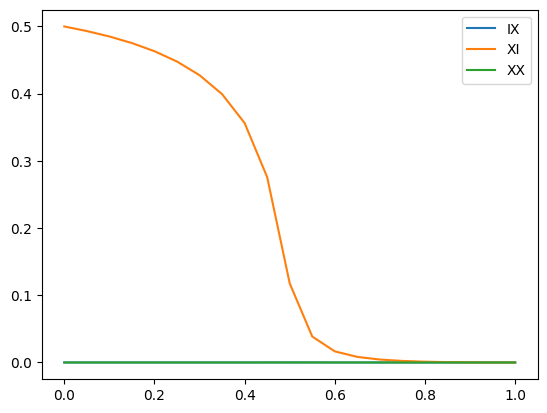

In [80]:
for i in range(len(non_trivial_bosonic_npc_symmetries)):
    plt.plot(
        interpolation_values,
        bosonic_operator_n_triv_proj_rep_exps[:, i],
    label = non_trivial_bosonic_npc_symmetries_labels[i]
    )

plt.legend()

In [81]:
bosonic_operator_n_non_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_operator_n_non_triv_proj_rep_exps.append(list())
    psi = loaded_data_non_triv_proj_rep[t]
    for op in non_trivial_bosonic_npc_symmetries:
        out = psi.expectation_value_multi_sites([op, 'N'], i0=100)
        bosonic_operator_n_non_triv_proj_rep_exps[-1].append(out)

bosonic_operator_n_non_triv_proj_rep_exps = np.array(bosonic_operator_n_non_triv_proj_rep_exps)

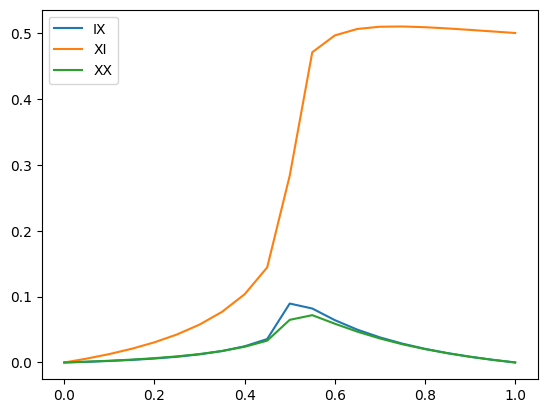

In [82]:
for i in range(len(non_trivial_bosonic_npc_symmetries)):
    plt.plot(
        interpolation_values,
        bosonic_operator_n_non_triv_proj_rep_exps[:, i],
    label = non_trivial_bosonic_npc_symmetries_labels[i]
    )

plt.legend()

In [83]:
def get_two_point_boson_fn_op_expectation(psi, distance, op):
    ops = [op, 'N'] + ['Id',]*(2*distance) + [op, 'N']

    left_site = 100 - 2 - 2*distance

    return psi.expectation_value_multi_sites(ops, left_site)

In [84]:
loaded_data_triv_proj_rep[0].get_B(0)

<npc.Array shape=(1, 4, 1) labels=['vL', 'p', 'vR']>

In [85]:
boosn_occupation_n_2_point_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_triv_proj_rep[t]
    boosn_occupation_n_2_point_triv_proj_rep.append(list())
    for op in non_trivial_bosonic_npc_symmetries:
        out = [
            get_two_point_boson_fn_op_expectation(psi, d, op)
            for d in distances
        ]
        boosn_occupation_n_2_point_triv_proj_rep[-1].append(out)

boosn_occupation_n_2_point_triv_proj_rep = np.array(
    boosn_occupation_n_2_point_triv_proj_rep
)

In [86]:
boson_occupation_n_correlation_triv_proj_rep = (
    boosn_occupation_n_2_point_triv_proj_rep
    - (np.array(bosonic_operator_n_triv_proj_rep_exps)**2)[..., np.newaxis]
)

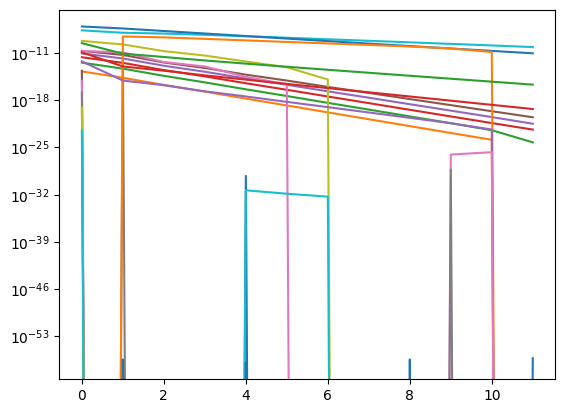

In [87]:
for X in boson_occupation_n_correlation_triv_proj_rep[:, 0, :]:
    plt.plot(X[:12])

plt.yscale('log')

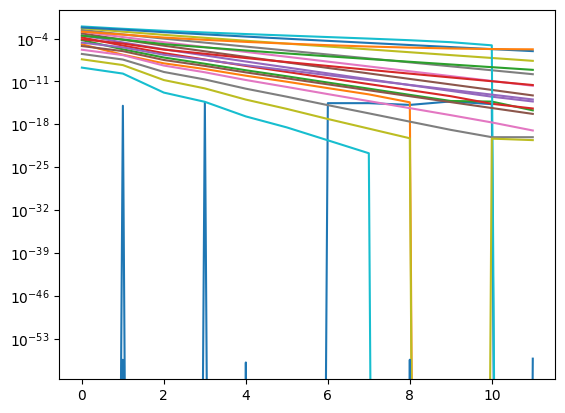

In [88]:
for X in boson_occupation_n_correlation_triv_proj_rep[:, 1, :]:
    plt.plot(X[:12])

plt.yscale('log')

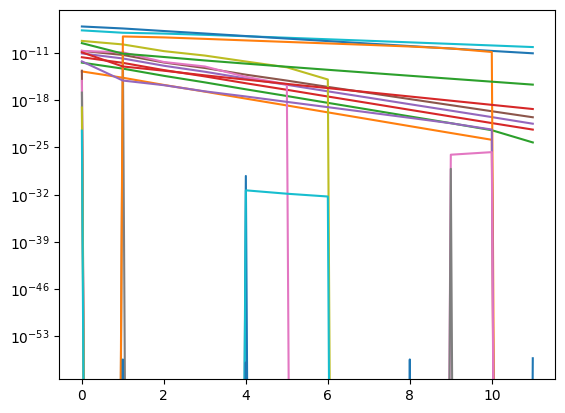

In [89]:
for X in boson_occupation_n_correlation_triv_proj_rep[:, 2, :]:
    plt.plot(X[:12])

plt.yscale('log')

In [90]:
boosn_occupation_n_2_point_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    boosn_occupation_n_2_point_non_triv_proj_rep.append(list())
    for op in non_trivial_bosonic_npc_symmetries:
        out = [
            get_two_point_boson_fn_op_expectation(psi, d, op)
            for d in distances
        ]
        boosn_occupation_n_2_point_non_triv_proj_rep[-1].append(out)

boosn_occupation_n_2_point_non_triv_proj_rep = np.array(
    boosn_occupation_n_2_point_non_triv_proj_rep
)

In [91]:
boson_occupation_n_correlation_non_triv_proj_rep = (
    boosn_occupation_n_2_point_non_triv_proj_rep
    - (np.array(bosonic_operator_n_non_triv_proj_rep_exps)**2)[..., np.newaxis]
)

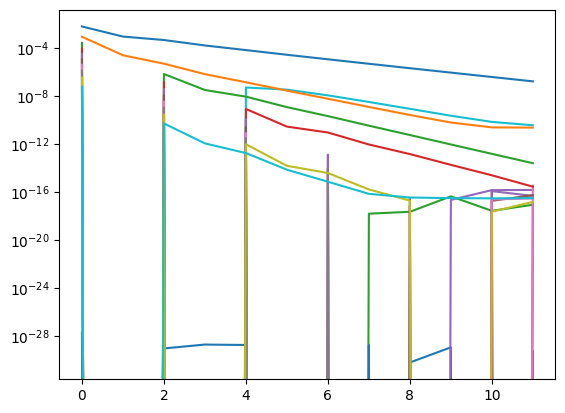

In [92]:
for X in boson_occupation_n_correlation_non_triv_proj_rep[:, 0, :]:
    plt.plot(X[:12])

plt.yscale('log')

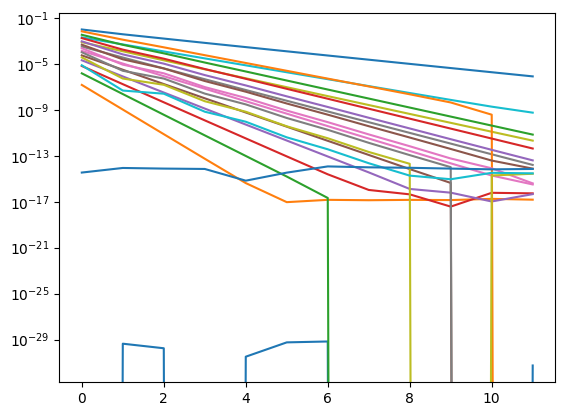

In [93]:
for X in boson_occupation_n_correlation_non_triv_proj_rep[:, 1, :]:
    plt.plot(X[:12])

plt.yscale('log')

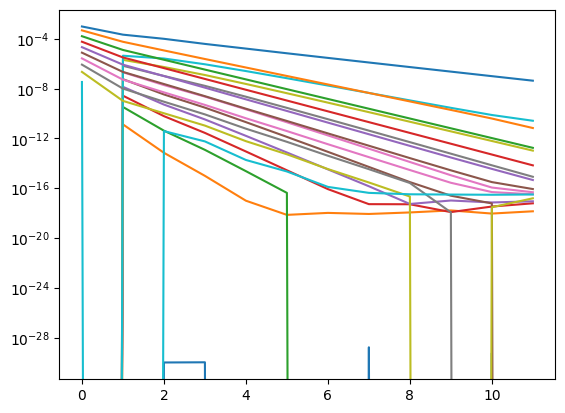

In [94]:
for X in boson_occupation_n_correlation_non_triv_proj_rep[:, 2, :]:
    plt.plot(X[:12])

plt.yscale('log')

In [95]:
non_trivial_bosonic_npc_symmetries_labels

['IX', 'XI', 'XX']

#### Plot

In [96]:
boson_op_correlation_lengths_triv_proj_rep[:, 0]

array([0.        , 0.40747345, 0.4155897 , 0.42757511, 0.44707303,
       0.48130195, 0.54154916, 0.64586556, 0.84137717, 1.32741006,
       1.2006655 , 1.29782923, 0.87124523, 0.66214118, 0.53848862,
       0.45329091, 0.38813153, 0.33377737, 0.28403423, 0.24138604,
       0.        ])

"\nfig.savefig(\n    r'plots/fermionic_state_correlation_lengths.png',\n    dpi=200,\n    bbox_inches='tight'\n)\n"

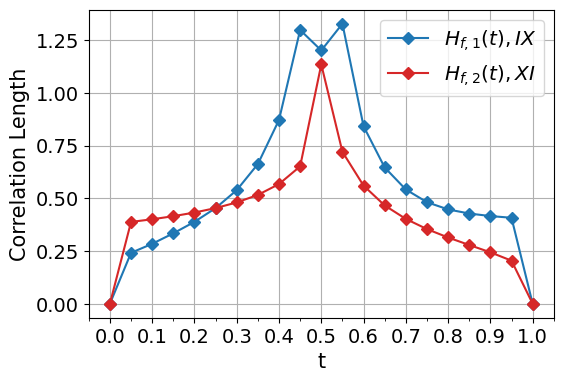

In [98]:
fig, ax = plt.subplots(figsize=(6, 4))

# Reverse interpolation values due to annoying ordering error I made.
ax.plot(
    interpolation_values[::-1],
    boson_op_correlation_lengths_triv_proj_rep[:, 0],
    color='tab:blue',
    marker='D',
    label=r'$H_{f,1}(t), IX$',
)

ax.plot(
    interpolation_values[::-1],
    boson_op_correlation_lengths_non_triv_proj_rep[:, 1],
    color='tab:red',
    marker='D',
    label=r'$H_{f,2}(t), XI$'
)

ax.grid()

ax.set_xticks(interpolation_values)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.tick_params(
    axis='both',
    which='major',
    labelsize=14
)

ax.set_xlabel("t", fontsize=15)
ax.set_ylabel("Correlation Length", fontsize=15)

ax.legend(
    fontsize='x-large'
)
"""
fig.savefig(
    r'plots/fermionic_state_correlation_lengths.png',
    dpi=200,
    bbox_inches='tight'
)
"""

## Z-like operators

In [466]:
np_z_01 = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, -1]
])

np_z_10 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, -1]
])

np_z_11 = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

In [467]:
bosonic_np_phase_operators = [
    np_z_01,
    np_z_10,
    np_z_11
]

bosonic_npc_phase_operators = [
    to_npc_array(X)
    for X in bosonic_np_phase_operators
]

In [468]:
boosn_phase_2_point_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_triv_proj_rep[t]
    boosn_phase_2_point_triv_proj_rep.append(list())
    for op in bosonic_npc_phase_operators:
        out = [
            get_two_point_boson_op_expectation(psi, d, op)
            for d in distances
        ]
        boosn_phase_2_point_triv_proj_rep[-1].append(out)

boosn_phase_2_point_triv_proj_rep = np.array(
    boosn_phase_2_point_triv_proj_rep
)

In [469]:
boosn_phase_2_point_triv_proj_rep.shape

(21, 3, 20)

In [470]:
bosonic_phase_operator_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_phase_operator_triv_proj_rep_exps.append(list())
    psi = loaded_data_triv_proj_rep[t]
    for op in bosonic_npc_phase_operators:
        out = psi.expectation_value(op, sites=[100,])[0]
        bosonic_phase_operator_triv_proj_rep_exps[-1].append(out)

bosonic_phase_operator_triv_proj_rep_exps = np.array(bosonic_phase_operator_triv_proj_rep_exps)

In [471]:
boson_phase_operator_correlation_triv_proj_rep = (
    boosn_phase_2_point_triv_proj_rep
    - (np.array(bosonic_phase_operator_triv_proj_rep_exps)**2)[..., np.newaxis]
)

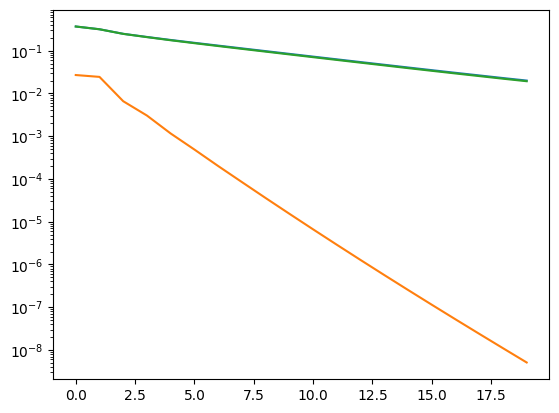

In [472]:
for X in boson_phase_operator_correlation_triv_proj_rep[9:12, 0, :]:
    plt.plot(X)

plt.yscale('log')

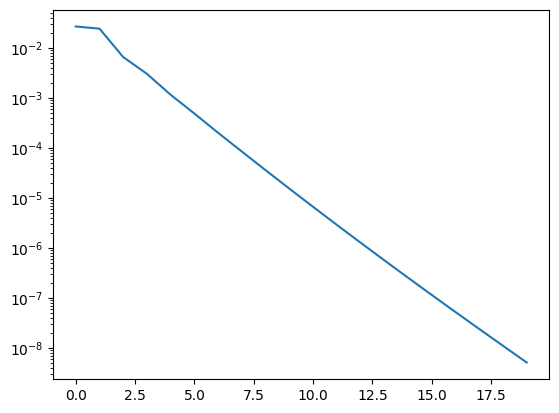

In [473]:
plt.plot(boson_phase_operator_correlation_triv_proj_rep[10, 0, :])
plt.yscale('log')

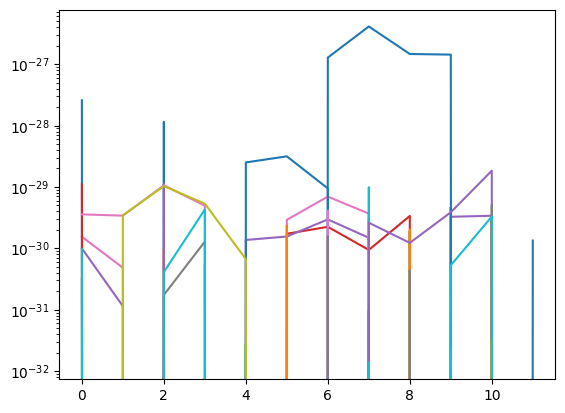

In [474]:
for X in boson_phase_operator_correlation_triv_proj_rep[:, 1, :]:
    plt.plot(X[:12])

plt.yscale('log')

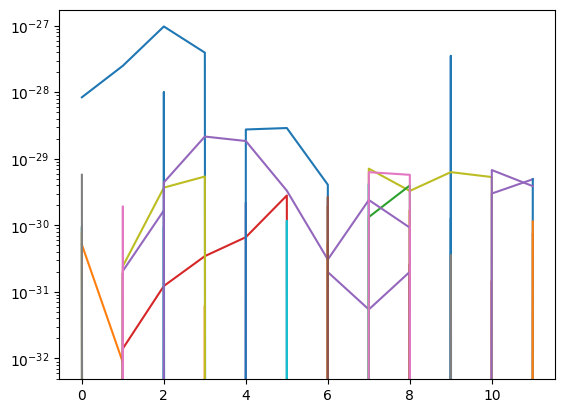

In [475]:
for X in boson_phase_operator_correlation_triv_proj_rep[:, 2, :]:
    plt.plot(X[:12])

plt.yscale('log')

In [476]:
X = boson_phase_operator_correlation_triv_proj_rep[:, 0, :]
num_sites = X.shape[-1]

boson_phase_op_correlation_lengths_triv_proj_rep = (num_sites - 1)/np.log(X[...,0]/X[...,-1])
boson_phase_op_correlation_lengths_triv_proj_rep[0] = 0
boson_phase_op_correlation_lengths_triv_proj_rep[-1] = 0

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/2906397705.py:4: RuntimeWarning: invalid value encountered in log
  boson_phase_op_correlation_lengths_triv_proj_rep = (num_sites - 1)/np.log(X[...,0]/X[...,-1])


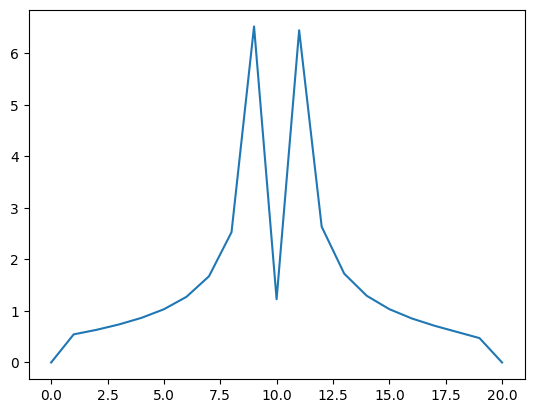

In [477]:
plt.plot(boson_phase_op_correlation_lengths_triv_proj_rep)

In [478]:
boosn_phase_2_point_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    boosn_phase_2_point_non_triv_proj_rep.append(list())
    for op in bosonic_npc_phase_operators:
        out = [
            get_two_point_boson_op_expectation(psi, d, op)
            for d in distances
        ]
        boosn_phase_2_point_non_triv_proj_rep[-1].append(out)

boosn_phase_2_point_non_triv_proj_rep = np.array(
    boosn_phase_2_point_non_triv_proj_rep
)

In [479]:
boosn_phase_2_point_non_triv_proj_rep.shape

(21, 3, 20)

In [480]:
bosonic_phase_operator_non_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_phase_operator_non_triv_proj_rep_exps.append(list())
    psi = loaded_data_non_triv_proj_rep[t]
    for op in bosonic_npc_phase_operators:
        out = psi.expectation_value(op, sites=[100,])[0]
        bosonic_phase_operator_non_triv_proj_rep_exps[-1].append(out)

bosonic_phase_operator_non_triv_proj_rep_exps = np.array(bosonic_phase_operator_non_triv_proj_rep_exps)

In [481]:
boson_phase_operator_correlation_non_triv_proj_rep = (
    boosn_phase_2_point_non_triv_proj_rep
    - (np.array(bosonic_phase_operator_non_triv_proj_rep_exps)**2)[..., np.newaxis]
)

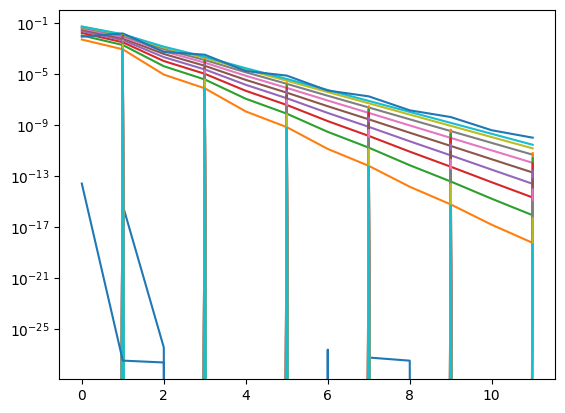

In [482]:
for X in boson_phase_operator_correlation_non_triv_proj_rep[:, 0, :]:
    plt.plot(X[:12])

plt.yscale('log')

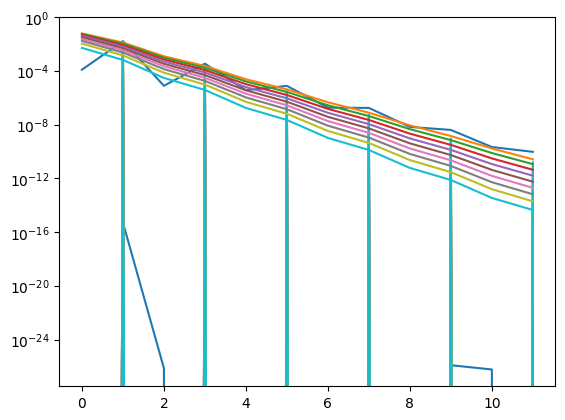

In [483]:
for X in boson_phase_operator_correlation_non_triv_proj_rep[:, 1, :]:
    plt.plot(X[:12])

plt.yscale('log')

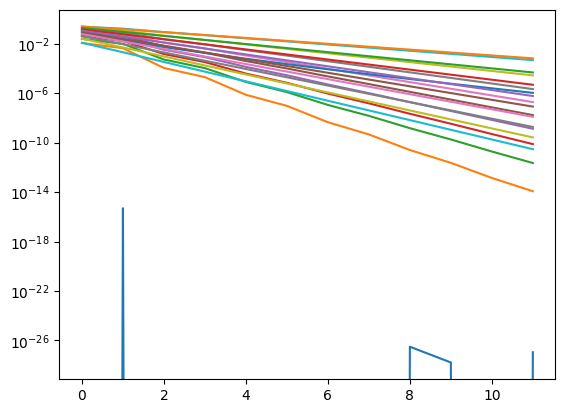

In [484]:
for X in boson_phase_operator_correlation_non_triv_proj_rep[:, 2, :]:
    plt.plot(X[:12])

plt.yscale('log')

In [485]:
X = boson_phase_operator_correlation_non_triv_proj_rep[:, 2, :]
num_sites = X.shape[-1]

boson_phase_op_correlation_lengths_non_triv_proj_rep = (num_sites - 1)/np.log(X[...,0]/X[...,-1])
boson_phase_op_correlation_lengths_non_triv_proj_rep[0] = 0
boson_phase_op_correlation_lengths_non_triv_proj_rep[-1] = 0

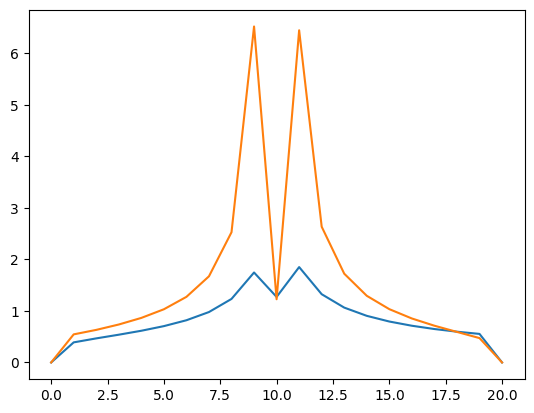

In [486]:
plt.plot(boson_phase_op_correlation_lengths_non_triv_proj_rep)
plt.plot(boson_phase_op_correlation_lengths_triv_proj_rep)

In [489]:
with open(r'../make_plots/data/fermionic_cases/200_site_mps_iz_triv_correlation_lengths.pkl', 'wb') as f:
    pickle.dump(
        {
            'interpolation_values': interpolation_values,
            'correlation_lengths': boson_phase_op_correlation_lengths_triv_proj_rep
        },
        f
    )

with open(r'../make_plots/data/fermionic_cases/200_site_mps_zz_non_triv_correlation_lengths.pkl', 'wb') as f:
    pickle.dump(
        {
            'interpolation_values': interpolation_values,
            'correlation_lengths': boson_phase_op_correlation_lengths_non_triv_proj_rep
        },
        f
    )

## $Z\hat{n}$-like operators

In [129]:
bosonic_phase_operator_n_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_phase_operator_n_triv_proj_rep_exps.append(list())
    psi = loaded_data_triv_proj_rep[t]
    for op in bosonic_npc_phase_operators:
        out = psi.expectation_value_multi_sites([op, 'N'], i0=100)
        bosonic_phase_operator_n_triv_proj_rep_exps[-1].append(out)

bosonic_phase_operator_n_triv_proj_rep_exps = np.array(bosonic_phase_operator_n_triv_proj_rep_exps)

In [130]:
boson_phase_operator_n_2_point_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_triv_proj_rep[t]
    boson_phase_operator_n_2_point_triv_proj_rep.append(list())
    for op in bosonic_npc_phase_operators:
        out = [
            get_two_point_boson_fn_op_expectation(psi, d, op)
            for d in distances
        ]
        boson_phase_operator_n_2_point_triv_proj_rep[-1].append(out)

boson_phase_operator_n_2_point_triv_proj_rep = np.array(
    boson_phase_operator_n_2_point_triv_proj_rep
)

In [131]:
boson_phase_operator_n_correlation_triv_proj_rep = (
    boson_phase_operator_n_2_point_triv_proj_rep
    - (np.array(bosonic_phase_operator_n_triv_proj_rep_exps)**2)[..., np.newaxis]
)

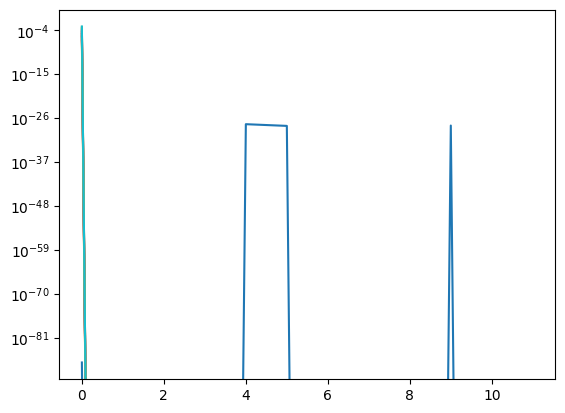

In [132]:
for X in boson_phase_operator_n_correlation_triv_proj_rep[:, 0, :]:
    plt.plot(X[:12])

plt.yscale('log')

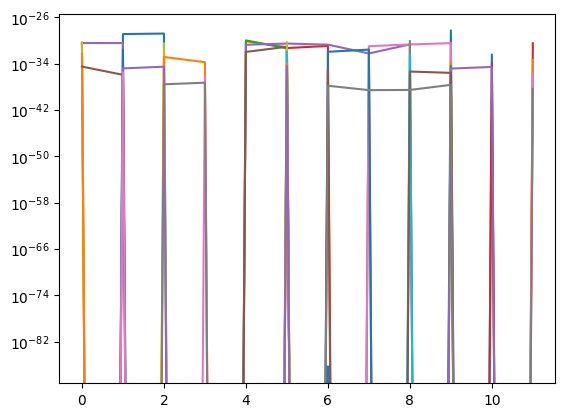

In [133]:
for X in boson_phase_operator_n_correlation_triv_proj_rep[:, 1, :]:
    plt.plot(X[:12])

plt.yscale('log')

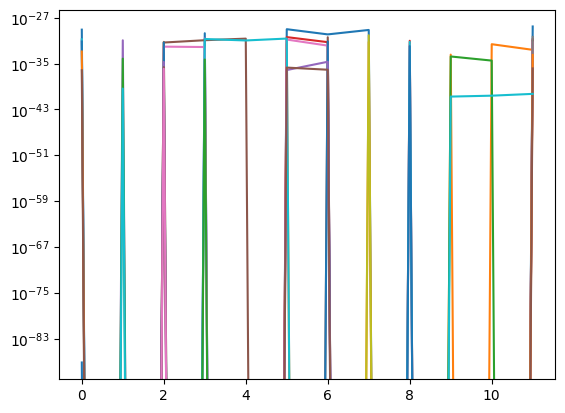

In [134]:
for X in boson_phase_operator_n_correlation_triv_proj_rep[:, 2, :]:
    plt.plot(X[:12])

plt.yscale('log')

In [135]:
bosonic_phase_operator_n_non_triv_proj_rep_exps = list()

for t in interpolation_values:
    bosonic_phase_operator_n_non_triv_proj_rep_exps.append(list())
    psi = loaded_data_non_triv_proj_rep[t]
    for op in bosonic_npc_phase_operators:
        out = psi.expectation_value_multi_sites([op, 'N'], i0=100)
        bosonic_phase_operator_n_non_triv_proj_rep_exps[-1].append(out)

bosonic_phase_operator_n_non_triv_proj_rep_exps = np.array(bosonic_phase_operator_n_non_triv_proj_rep_exps)

In [136]:
boson_phase_operator_n_2_point_non_triv_proj_rep = list()

for t in interpolation_values:
    psi = loaded_data_non_triv_proj_rep[t]
    boson_phase_operator_n_2_point_non_triv_proj_rep.append(list())
    for op in bosonic_npc_phase_operators:
        out = [
            get_two_point_boson_fn_op_expectation(psi, d, op)
            for d in distances
        ]
        boson_phase_operator_n_2_point_non_triv_proj_rep[-1].append(out)

boson_phase_operator_n_2_point_non_triv_proj_rep = np.array(
    boson_phase_operator_n_2_point_non_triv_proj_rep
)

In [137]:
boson_phase_operator_n_correlation_non_triv_proj_rep = (
    boson_phase_operator_n_2_point_non_triv_proj_rep
    - (np.array(bosonic_phase_operator_n_non_triv_proj_rep_exps)**2)[..., np.newaxis]
)

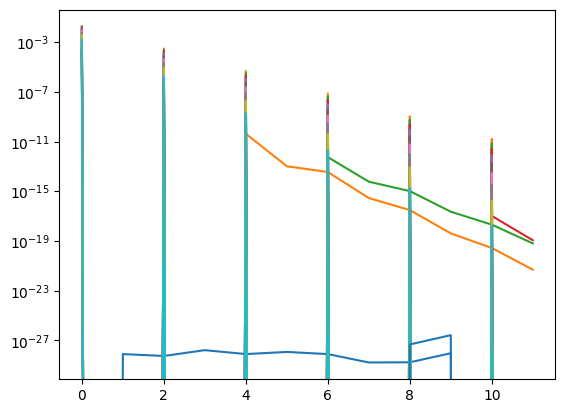

In [138]:
for X in boson_phase_operator_n_correlation_non_triv_proj_rep[:, 0, :]:
    plt.plot(X[:12])

plt.yscale('log')

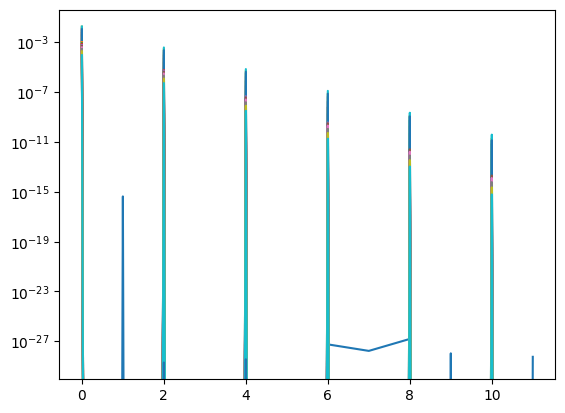

In [139]:
for X in boson_phase_operator_n_correlation_non_triv_proj_rep[:, 1, :]:
    plt.plot(X[:12])

plt.yscale('log')

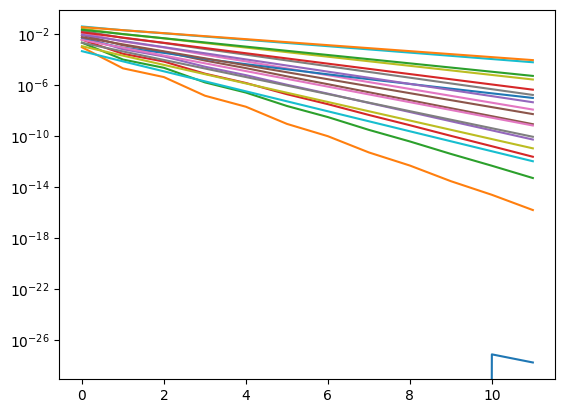

In [140]:
for X in boson_phase_operator_n_correlation_non_triv_proj_rep[:, 2, :]:
    plt.plot(X[:12])

plt.yscale('log')

In [141]:
X = boson_phase_operator_n_correlation_non_triv_proj_rep[:, 2, :]
num_sites = X.shape[-1]

boson_phase_op_correlation_lengths_non_triv_proj_rep = (num_sites - 1)/np.log(X[...,0]/X[...,-1])
boson_phase_op_correlation_lengths_non_triv_proj_rep[0] = 0
boson_phase_op_correlation_lengths_non_triv_proj_rep[-1] = 0

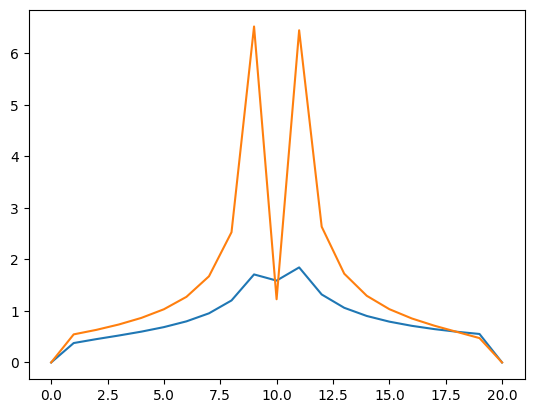

In [142]:
plt.plot(boson_phase_op_correlation_lengths_non_triv_proj_rep)
plt.plot(boson_phase_op_correlation_lengths_triv_proj_rep)

## Sweep operators

In [144]:
np_z_00 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

np_z_01 = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, -1]
])

np_z_10 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, -1]
])

np_z_11 = np.array([
    [1, 0, 0, 0],
    [0, -1, 0, 0],
    [0, 0, -1, 0],
    [0, 0, 0, 1]
])

In [146]:
bosonic_np_phase_operators = [
    np_z_00,
    np_z_01,
    np_z_10,
    np_z_11
]

In [147]:
bosonic_np_operators = [
    [X @ Y for Y in bosonic_np_phase_operators]
    for X in bosonic_np_symmetries
]

In [148]:
bosonic_npc_operators = [
    [
        to_npc_array(X) for X in l
    ]
    for l in bosonic_np_operators
]

In [153]:
def get_two_point_fn_op_expectation(psi, distance, op, number_operator=False):
    fermion_op = 'N' if number_operator else 'Id'
    ops = (
        [op, fermion_op]
        + ['Id',]*(2*(distance-1))
        + [op, fermion_op]
    )

    left_site = 100 - 2 - 2*distance

    return psi.expectation_value_multi_sites(ops, left_site)

In [143]:
loaded_data = [
    loaded_data_triv_proj_rep,
    loaded_data_non_triv_proj_rep
]

In [185]:
operator_exps = np.zeros((2, 21, 4, 4, 2)) 

for i1, data_dict in enumerate(loaded_data):
    for i2, t in enumerate(interpolation_values):
        psi = data_dict[t]
        for i3, op_l in enumerate(bosonic_npc_operators):
            for i4, op in enumerate(op_l):
                for i5, n_op in enumerate([False, True]):
                    if n_op:
                        out = psi.expectation_value_multi_sites([op, 'N'], i0=100)
                    else:
                        out = psi.expectation_value(op, sites=[100,])[0]
                    operator_exps[i1, i2, i3, i4, i5] = out

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/142152675.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  operator_exps[i1, i2, i3, i4, i5] = out


In [186]:
distances

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [187]:
operator_2_points = np.zeros((2, 21, 4, 4, 2, 20)) 

for i1, data_dict in enumerate(loaded_data):
    for i2, t in enumerate(interpolation_values):
        psi = data_dict[t]
        for i3, op_l in enumerate(bosonic_npc_operators):
            for i4, op in enumerate(op_l):
                for i5, n_op in enumerate([False, True]):
                    for i6, d in enumerate(distances):
                        out = get_two_point_fn_op_expectation(psi, d, op, n_op)
                        operator_2_points[i1, i2, i3, i4, i5, i6] = out

In [188]:
operator_correlations = (
    operator_2_points
    - (operator_exps**2)[..., np.newaxis]
)

In [189]:
log_operator_correlations = np.log(operator_correlations)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/2258818106.py:1: RuntimeWarning: divide by zero encountered in log
  log_operator_correlations = np.log(operator_correlations)
/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/2258818106.py:1: RuntimeWarning: invalid value encountered in log
  log_operator_correlations = np.log(operator_correlations)


In [190]:
log_operator_correlations.shape

(2, 21, 4, 4, 2, 20)

In [191]:
flattened_log_operator_correlations = np.reshape(
    log_operator_correlations,
    (2, 21, 32, 20)
)

In [192]:
average_correlations = np.nanmean(
    flattened_log_operator_correlations[..., 1:, 6],
    axis=1
)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/555408753.py:1: RuntimeWarning: Mean of empty slice
  average_correlations = np.nanmean(


In [193]:
average_correlations.shape

(2, 31)

In [194]:
max_correlations_index = np.argmax(
    average_correlations,
    axis=1
)

In [195]:
max_correlations_index

array([2, 4])

In [196]:
average_correlations

array([[ -21.35518138,   -8.37437641,           nan,  -68.12709453,
         -74.21472745,  -67.72714896,  -73.57966849,  -18.50692535,
         -33.0273266 ,  -13.94044584,          -inf,  -68.30389521,
         -81.02196387,  -78.69339313,          -inf,          -inf,
         -21.35898091,   -8.37437641,           nan,  -74.78712315,
        -105.07511554,  -75.00898844,  -81.7971235 ,  -18.50690954,
         -33.02732659,  -13.94044584,          -inf,  -78.25527588,
        -100.69128454,  -71.68880448,  -79.12821342],
       [ -24.37880604,  -22.1763678 ,  -29.90430362,  -17.10951816,
                  nan,  -13.173425  ,  -11.97776391,  -22.09774452,
         -21.99629215,  -15.72154183,  -19.22920287,  -31.45834356,
         -17.52599071,  -15.71324302,  -66.2488671 ,          -inf,
         -23.33640398,  -26.28811456,  -65.19036516,  -21.63805611,
         -30.89231444,  -15.39425239,  -19.12627988,  -25.76030495,
         -26.80994441,  -21.60277335,  -22.43036174,  -23.2898

In [197]:
flattened_operator_correlations = np.reshape(
    operator_correlations,
    (2, 21, 32, 20)
)

In [198]:
average_correlations = np.nanmean(
    flattened_operator_correlations[..., 6],
    axis=1
)

In [199]:
average_correlations.shape

(2, 32)

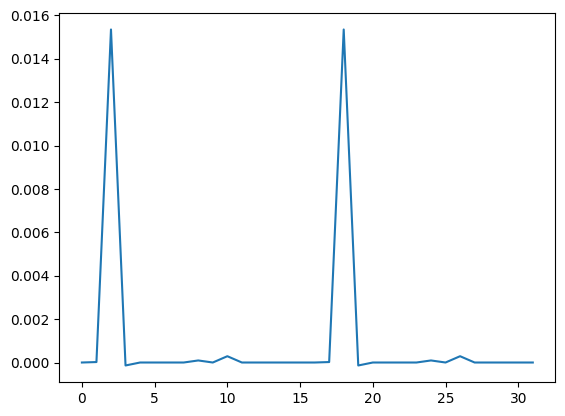

In [200]:
plt.plot(average_correlations[0])

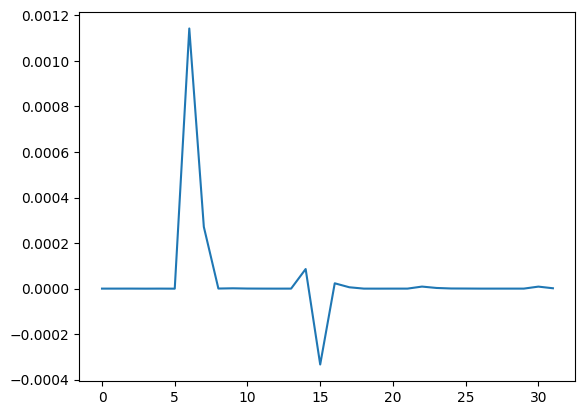

In [201]:
plt.plot(average_correlations[1])

In [203]:
np.round(average_correlations[0], 4)

array([-0.    ,  0.    ,  0.0154, -0.0001, -0.    , -0.    , -0.    ,
        0.    ,  0.0001,  0.    ,  0.0003,  0.    , -0.    , -0.    ,
       -0.    , -0.    , -0.    ,  0.    ,  0.0154, -0.0001, -0.    ,
        0.    , -0.    , -0.    ,  0.0001,  0.    ,  0.0003,  0.    ,
       -0.    , -0.    , -0.    , -0.    ])

2 and 18

In [207]:
np.unravel_index(2, (4,4,2))

(0, 1, 0)

In [208]:
np.unravel_index(18, (4,4,2))

(2, 1, 0)

$IZ$ and $XZ$

In [205]:
np.round(average_correlations[1], 4)

array([ 0.    ,  0.    ,  0.    , -0.    ,  0.    , -0.    ,  0.0011,
        0.0003,  0.    ,  0.    ,  0.    ,  0.    , -0.    ,  0.    ,
        0.0001, -0.0003,  0.    ,  0.    , -0.    , -0.    , -0.    ,
       -0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ])

Just 6

In [330]:
(
    np.unravel_index(6, (4,4,2)),
    np.unravel_index(7, (4,4,2)),
    np.unravel_index(14, (4,4,2)),
    np.unravel_index(15, (4,4,2))
)

((0, 3, 0), (0, 3, 1), (1, 3, 0), (1, 3, 1))

$ZZ$ (I thought we tried this one already...?)

In [211]:
operator_correlations.shape

(2, 21, 4, 4, 2, 20)

In [216]:
max_triv_correlations = operator_correlations[0, :, 0, 1, 0, :]
max_non_triv_correlations = operator_correlations[1, :, 0, 3, 0, :]

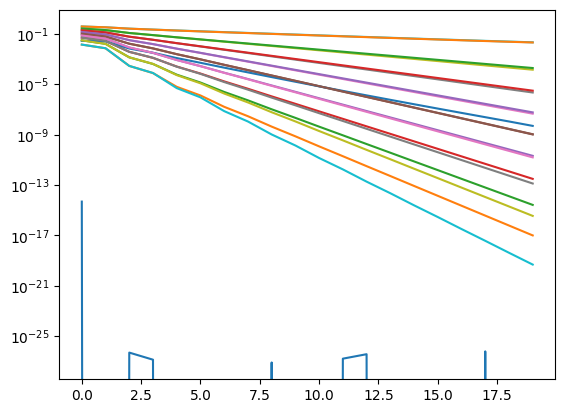

In [217]:
for X in max_triv_correlations:
    plt.plot(X)

plt.yscale('log')

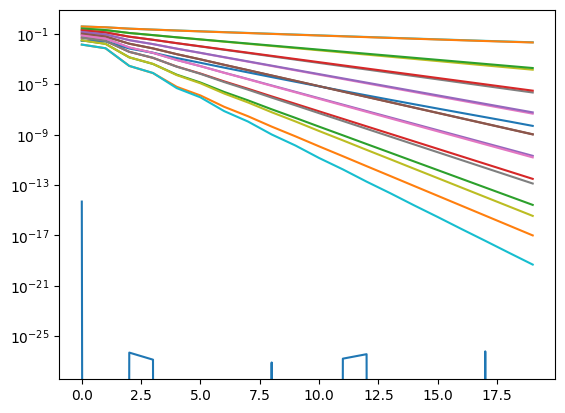

In [232]:
for X in operator_correlations[0, :, 2, 1, 0, :]:
    plt.plot(X)

plt.yscale('log')

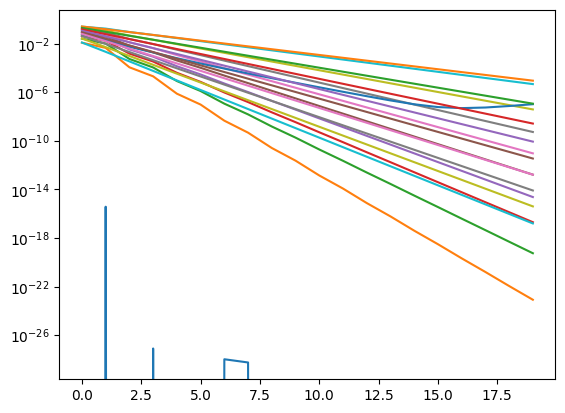

In [218]:
for X in max_non_triv_correlations:
    plt.plot(X)

plt.yscale('log')

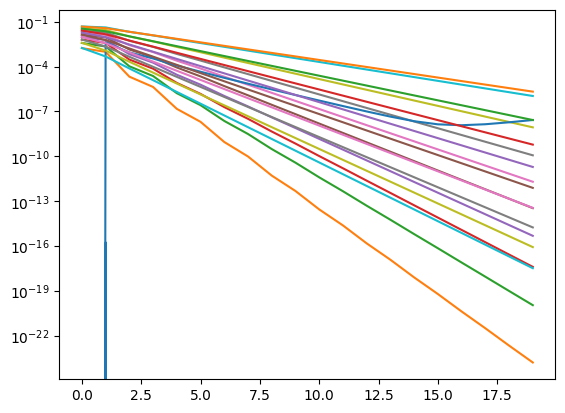

In [229]:
for X in operator_correlations[1, :, 0, 3, 1, :]:
    plt.plot(X)

plt.yscale('log')

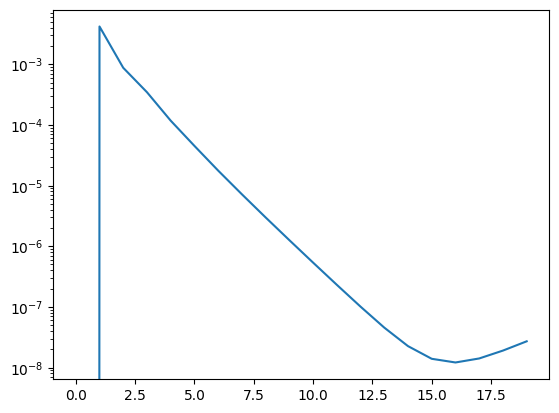

In [231]:
plt.plot(operator_correlations[1, 10, 0, 3, 1, :])

plt.yscale('log')

In [220]:
flattened_operator_correlations.shape

(2, 21, 32, 20)

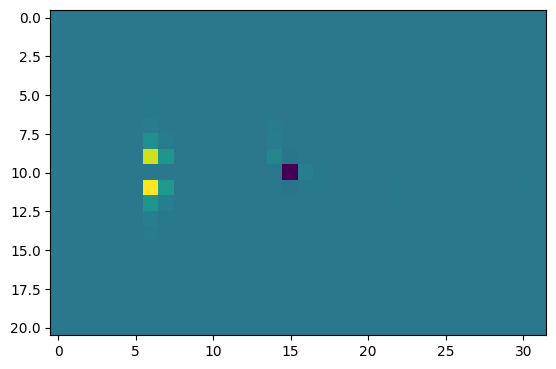

In [221]:
plt.imshow(flattened_operator_correlations[1, ..., 6])

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/739520963.py:2: RuntimeWarning: divide by zero encountered in log
  np.log(np.abs(flattened_operator_correlations[1, ..., 6]))


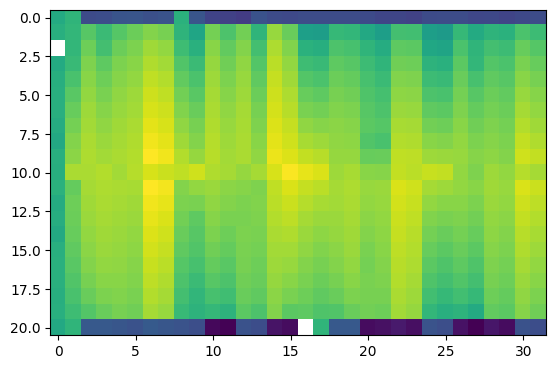

In [226]:
plt.imshow(
    np.log(np.abs(flattened_operator_correlations[1, ..., 6]))
)

Not much variation here...

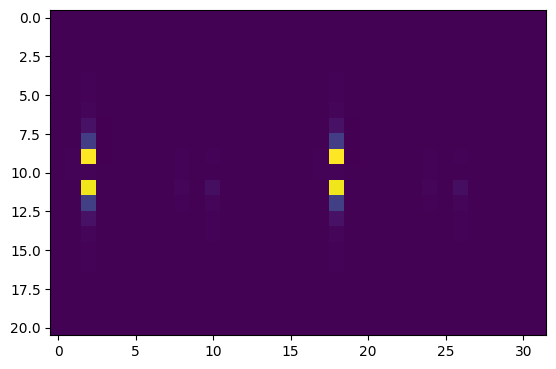

In [224]:
plt.imshow(flattened_operator_correlations[0, ..., 6])

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/1003207200.py:2: RuntimeWarning: divide by zero encountered in log
  np.log(np.abs(flattened_operator_correlations[0, ..., 6]))


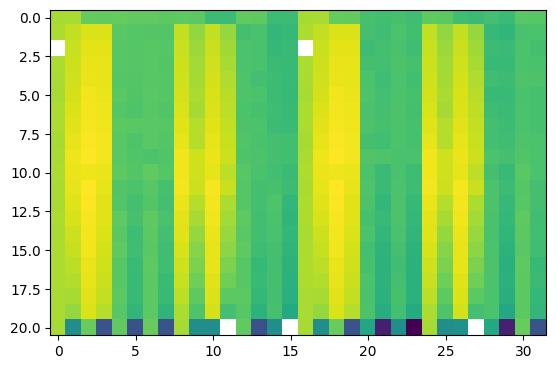

In [227]:
plt.imshow(
    np.log(np.abs(flattened_operator_correlations[0, ..., 6]))
)

In [346]:
X = operator_correlations[1, :, :2, 3, :, :]
X = np.delete(X, 10, axis=0)
num_sites = X.shape[-1]

corr_lengths = (num_sites - 1)/np.log(X[...,0]/X[...,-1])
corr_lengths[0] = 0
corr_lengths[-1] = 0
corr_lengths = np.reshape(corr_lengths, [corr_lengths.shape[0], -1])

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/1473350167.py:5: RuntimeWarning: invalid value encountered in log
  corr_lengths = (num_sites - 1)/np.log(X[...,0]/X[...,-1])


In [347]:
corr_lengths.shape

(20, 4)

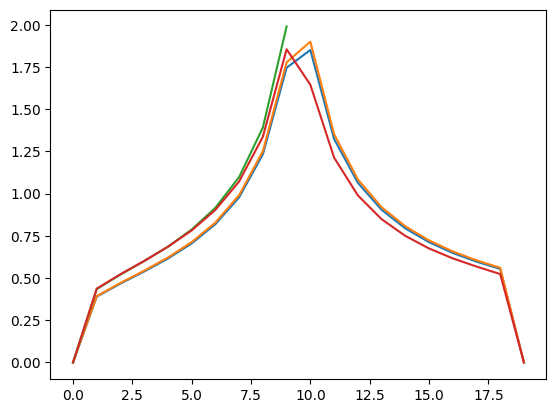

In [348]:
for i in range(corr_lengths.shape[1]):
    plt.plot(corr_lengths[:, i])

In [349]:
X = operator_correlations[0, :, 0, 1, 0, :]
X = np.delete(X, 10, axis=0)
num_sites = X.shape[-1]

corr_lengths = (num_sites - 1)/np.log(X[...,0]/X[...,-1])
corr_lengths[0] = 0
corr_lengths[-1] = 0

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/2822924046.py:5: RuntimeWarning: invalid value encountered in log
  corr_lengths = (num_sites - 1)/np.log(X[...,0]/X[...,-1])


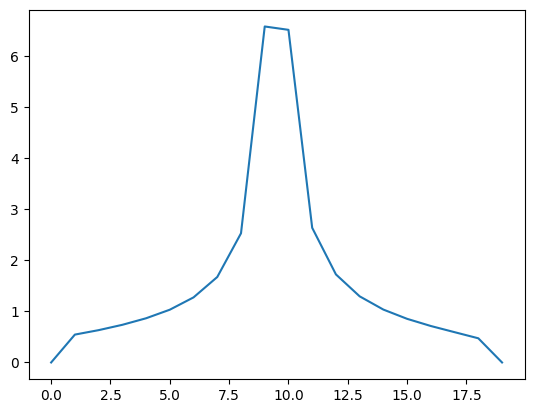

In [350]:
plt.plot(corr_lengths)

In [351]:
X = operator_correlations[0, :, 2, 1, 0, :]
X = np.delete(X, 10, axis=0)
num_sites = X.shape[-1]

corr_lengths = (num_sites - 1)/np.log(X[...,0]/X[...,-1])
corr_lengths[0] = 0
corr_lengths[-1] = 0

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/444380357.py:5: RuntimeWarning: invalid value encountered in log
  corr_lengths = (num_sites - 1)/np.log(X[...,0]/X[...,-1])


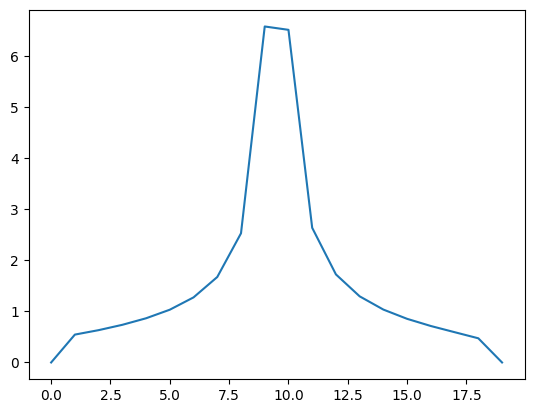

In [352]:
plt.plot(corr_lengths)

Just compute all of them...

In [251]:
X = (operator_correlations.copy())
X = np.delete(X, 10, axis=1)
num_sites = X.shape[-1]

corr_lengths = (num_sites - 1)/np.log(X[...,0]/X[...,-1])
corr_lengths[:, 0] = 0
corr_lengths[:, -1] = 0

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/789685060.py:5: RuntimeWarning: invalid value encountered in divide
  corr_lengths = (num_sites - 1)/np.log(X[...,0]/X[...,-1])
/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/789685060.py:5: RuntimeWarning: divide by zero encountered in log
  corr_lengths = (num_sites - 1)/np.log(X[...,0]/X[...,-1])
/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/789685060.py:5: RuntimeWarning: invalid value encountered in log
  corr_lengths = (num_sites - 1)/np.log(X[...,0]/X[...,-1])
/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/789685060.py:5: RuntimeWarning: divide by zero encountered in divide
  corr_lengths = (num_sites - 1)/np.log(X[...,0]/X[...,-1])


In [252]:
corr_lengths.shape

(2, 20, 4, 4, 2)

In [253]:
sub_corr_lengths = corr_lengths[:, 9]

In [254]:
sub_corr_lengths[0]

array([[[ -7.19954045,          nan],
        [  6.57312318,   2.76984241],
        [ 84.87764973,  -6.88127578],
        [135.89570411,  -8.67968776]],

       [[  3.04504799,          nan],
        [  1.78257036,          nan],
        [         nan,  -8.98393765],
        [         nan,          nan]],

       [[ -7.01611809,          nan],
        [  6.57312318,   2.76984241],
        [  3.60272639,          nan],
        [         nan,   2.64922169]],

       [[  3.04504799,          nan],
        [  1.78257036,          nan],
        [         nan,   3.10702056],
        [  9.91077936, -10.75122454]]])

In [255]:
sub_corr_lengths[1]

array([[[-21.25712688,          nan],
        [  0.51150147,   0.49119785],
        [         nan,          nan],
        [  1.74612417,   1.77841731]],

       [[         nan,   1.57565056],
        [  0.53477486,   0.54952248],
        [  0.48570776,   0.50734201],
        [  1.99050595,   1.85548828]],

       [[  1.31892478,   1.31345153],
        [  0.53512795,   0.48824335],
        [         nan,          nan],
        [  1.21961001,   1.37165073]],

       [[         nan,          nan],
        [  0.51576882,   0.50671808],
        [  0.48842527,   0.48547817],
        [         nan,          nan]]])

In [259]:
corr_lengths.shape

(2, 20, 4, 4, 2)

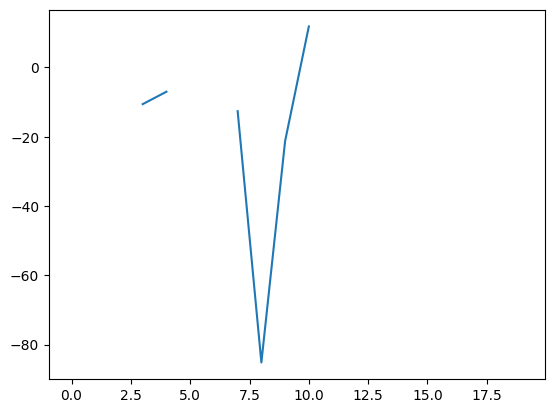

In [261]:
plt.plot(corr_lengths[1, :, 0, 0, 0])

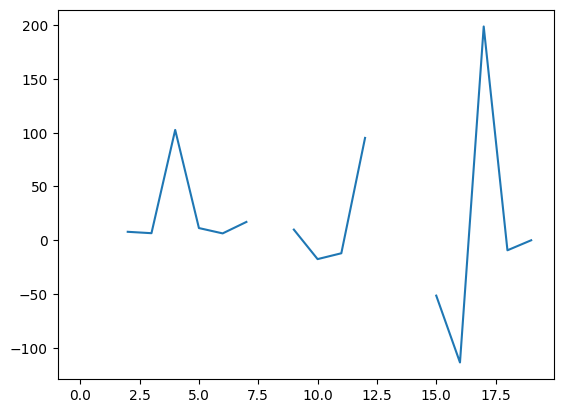

In [262]:
plt.plot(corr_lengths[0, :, -1, -1, 0])

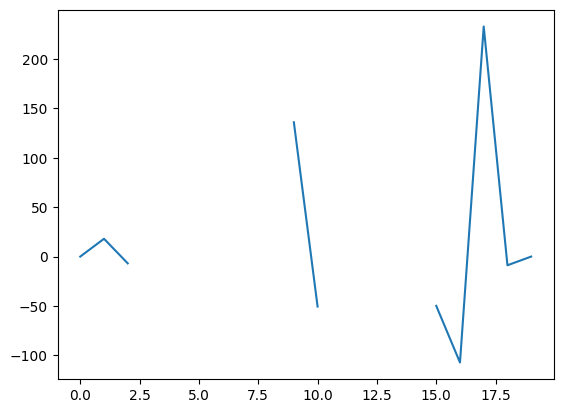

In [264]:
plt.plot(corr_lengths[0, :, 0, -1, 0])

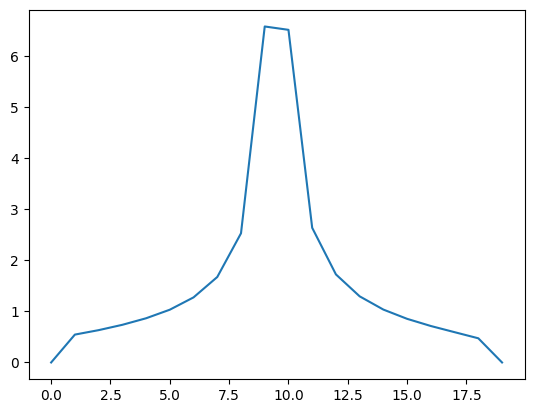

In [263]:
plt.plot(corr_lengths[0, :, 0, 1, 0])

## Check transfer matrix eigenvalues

In [397]:
def get_cental_transfer_matrix(psi, num_sites=40):
    total_num_sites = psi.L

    left_site = (total_num_sites - num_sites)//2

    transfer_matrices = (
        get_transfer_matrix_from_unitary(psi, i)
        for i in range(left_site, left_site + num_sites)
    )

    overall_transfer_matrix = reduce(multiply_transfer_matrices, transfer_matrices)

    return overall_transfer_matrix

In [398]:
def get_corr_length(tm, num_sites=40):
    np_tm = (
        tm
        .combine_legs([['vR', 'vR*'], ['vL', 'vL*']])
        .to_ndarray()
    )

    eigs = np.sort(np.linalg.eigvals(np_tm))[::-1]
    if len(eigs) >= 2:
        l1 = np.abs(eigs[0])
        l2 = np.abs(eigs[1])
        return np.array([-num_sites/np.log(l2/l1), eigs[0]])
    else:
        return np.array([0, eigs[0]])

In [399]:
num_sites=40

In [413]:
big_tms = [
    [
        get_cental_transfer_matrix(d[t], num_sites)
        for t in interpolation_values
    ]
    for d in loaded_data
]

In [415]:
tm_corr_lengths = list()

for l in big_tms:
    tm_corr_lengths.append(list())
    for tm in l:
        out = get_corr_length(tm, num_sites)
        tm_corr_lengths[-1].append(out)

tm_corr_lengths = np.array(tm_corr_lengths)

In [416]:
tm_corr_lengths.shape

(2, 21, 2)

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


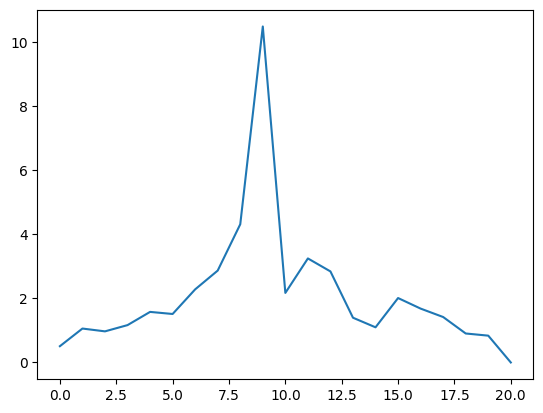

In [417]:
plt.plot(tm_corr_lengths[0, :, 0])

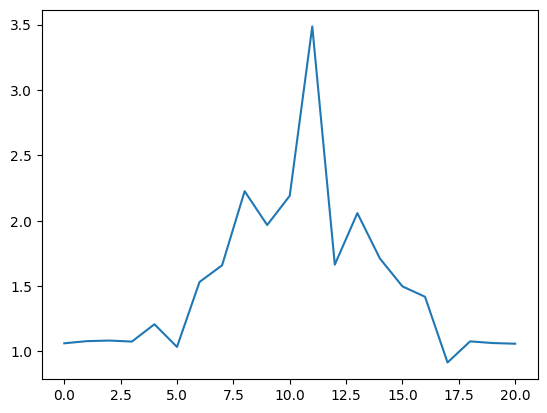

In [418]:
plt.plot(tm_corr_lengths[1, :, 0])

In [419]:
num_sites=10

In [421]:
big_tms = [
    [
        get_cental_transfer_matrix(d[t], num_sites)
        for t in interpolation_values
    ]
    for d in loaded_data
]

In [422]:
tm_corr_lengths = list()

for l in big_tms:
    tm_corr_lengths.append(list())
    for tm in l:
        out = get_corr_length(tm, num_sites)
        tm_corr_lengths[-1].append(out)

tm_corr_lengths = np.array(tm_corr_lengths)

In [423]:
tm_corr_lengths.shape

(2, 21, 2)

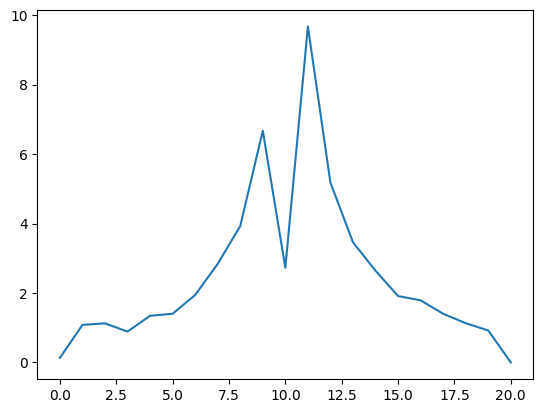

In [424]:
plt.plot(tm_corr_lengths[0, :, 0])

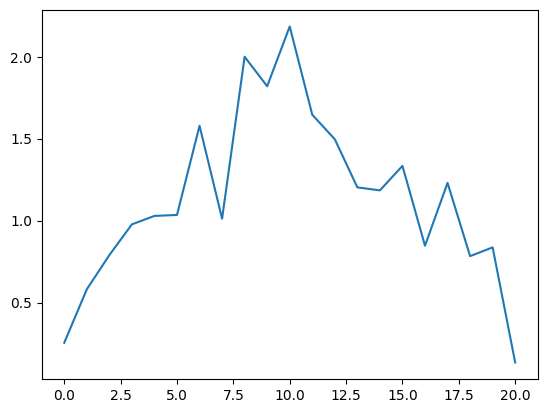

In [425]:
plt.plot(tm_corr_lengths[1, :, 0])

In [426]:
num_sites=2

In [427]:
big_tms = [
    [
        get_cental_transfer_matrix(d[t], num_sites)
        for t in interpolation_values
    ]
    for d in loaded_data
]

In [428]:
tm_corr_lengths = list()

for l in big_tms:
    tm_corr_lengths.append(list())
    for tm in l:
        out = get_corr_length(tm, num_sites)
        tm_corr_lengths[-1].append(out)

tm_corr_lengths = np.array(tm_corr_lengths)

In [429]:
tm_corr_lengths.shape

(2, 21, 2)

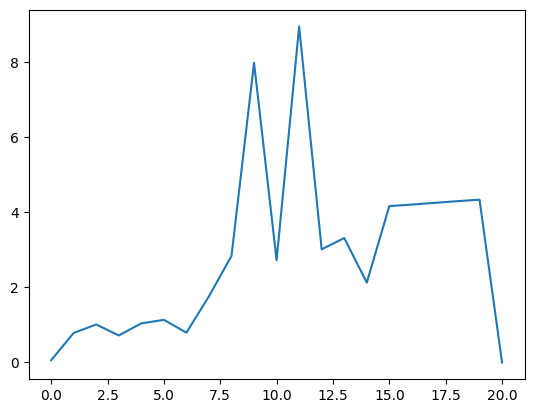

In [430]:
plt.plot(tm_corr_lengths[0, :, 0])

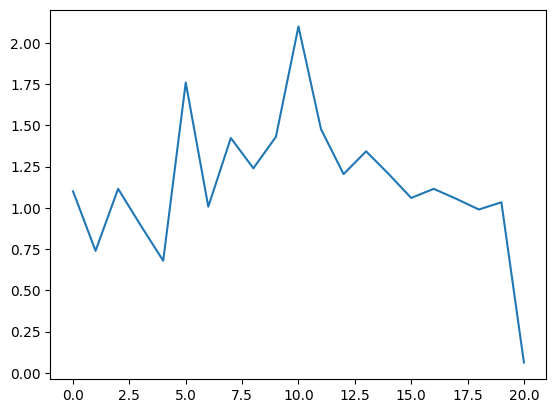

In [431]:
plt.plot(tm_corr_lengths[1, :, 0])

In [325]:
eigs

array([ 1.00000000e+00+4.53227750e-34j,  2.95536935e-02+6.81265358e-34j,
        1.81199010e-04+5.86240254e-30j,  4.87810815e-06+5.34503529e-22j,
        3.25343809e-06-5.98453877e-22j,  2.30745462e-06+4.86099391e-22j,
        1.98203716e-06-2.93598786e-30j,  5.74564618e-07+2.92646950e-22j,
        1.18578364e-07-6.61744489e-24j,  6.63067878e-08-2.15819165e-06j,
        6.63067878e-08+2.15819165e-06j,  4.98543466e-08+1.09044062e-23j,
        2.15640471e-08-1.30189331e-24j,  1.66667866e-08+3.40504378e-24j,
        1.18961766e-08+6.37889506e-31j,  2.51043815e-09-2.18992440e-28j,
        4.75231435e-10+4.52045162e-26j,  4.63353279e-10+2.75227638e-26j,
        1.28459540e-10-1.14065208e-08j,  1.28459540e-10+1.14065208e-08j,
        6.70240775e-12+6.70741034e-28j,  4.14880377e-12+8.37570902e-28j,
        1.11167481e-12+1.73915888e-12j,  1.11167481e-12-1.73915888e-12j,
        7.33324050e-13-2.25667533e-30j,  9.72690273e-15+1.05719235e-33j,
        2.79178158e-15-1.89140881e-33j,  3.85172725

In [326]:
test_tm = big_tms[0][10]

In [327]:
test_tm

<npc.Array shape=(8, 8, 8, 8) labels=['vL', 'vL*', 'vR', 'vR*']>

In [328]:
tm = test_tm
np_tm = (
    tm
    .combine_legs([['vR', 'vR*'], ['vL', 'vL*']])
    .to_ndarray()
)

eigs = np.sort(np.linalg.eigvals(np_tm))[::-1]

In [329]:
eigs

array([ 1.00000000e+00-8.40816906e-98j,  1.44939272e-01+8.40816906e-98j,
        3.65929011e-02+8.62991265e-77j,  5.17985567e-03-2.37058158e-74j,
        4.37026140e-03-2.42237053e-69j,  3.65285207e-04+1.44697758e-56j,
        3.00067263e-04+1.16062759e-48j,  1.59034981e-04-1.98212739e-32j,
        1.07922851e-04+1.88740903e-33j,  1.98525180e-05+1.51014279e-23j,
        1.23860843e-05+5.33914833e-23j,  1.04675385e-05+2.86583990e-24j,
        4.42382721e-06-2.26375973e-23j,  2.98122828e-06-7.73670053e-23j,
        2.83471320e-06+1.15798510e-23j,  1.79753338e-06+1.54783355e-22j,
        5.76945136e-07+1.50001793e-22j,  5.34493195e-07-1.32453314e-22j,
        8.26179106e-08-3.82455973e-25j,  6.26012476e-08+2.35081297e-07j,
        6.26012476e-08-2.35081297e-07j,  3.95107105e-08-8.93937477e-25j,
        2.39538912e-08-7.60703741e-25j,  1.54327336e-08-4.14012145e-25j,
        1.97285912e-09-3.01244827e-37j,  1.91865407e-09+2.10998844e-09j,
        1.91865407e-09-2.10998844e-09j,  5.23223250

## More operators

### Generate permutation matrices

In [365]:
from itertools import permutations, product

In [355]:
four_permutations = list(permutations(range(4)))

In [357]:
permutations_array = np.zeros((len(four_permutations), 4, 4))

for i, p in enumerate(four_permutations):
    for j, k in enumerate(p):
        permutations_array[i, j, k] = 1

### Generate phase gates

In [375]:
phases_array = np.zeros((2, 2, 2, 4, 4))
phases_array[..., 0, 0] = 1

for i, j, k in product(range(2), repeat=3):
    phases_array[i,j,k,1,1] = (-1)**(i)
    phases_array[i,j,k,2,2] = (-1)**(j)
    phases_array[i,j,k,3,3] = (-1)**(k)

phases_array = np.reshape(phases_array, (-1, 4, 4))

In [376]:
npc_phases[0]

<npc.Array shape=(4, 4) labels=['p', 'p*']>

### Another sweep

In [377]:
permutation_phase_np_operators = [
    [X @ Y for Y in phases_array]
    for X in permutations_array
]

In [378]:
permutation_phase_npc_operators = [
    [
        to_npc_array(X) for X in l
    ]
    for l in permutation_phase_np_operators
]

In [379]:
distances

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [383]:
def get_two_point_fn_op_expectation(psi, left_site, distance, op,
                                    number_operator=False):
    fermion_op = 'N' if number_operator else 'Id'
    ops = (
        [op, fermion_op]
        + ['Id',]*(2*(distance-1))
        + [op, fermion_op]
    )

    return psi.expectation_value_multi_sites(ops, left_site)

In [386]:
shape = (
    2,
    21,
    len(permutations_array),
    len(phases_array),
    2,
    len(distances)+1
)
operator_exps = np.zeros(shape) 

for i1, data_dict in enumerate(loaded_data):
    for i2, t in enumerate(interpolation_values):
        psi = data_dict[t]
        for i3, op_l in enumerate(permutation_phase_npc_operators):
            for i4, op in enumerate(op_l):
                for i5, n_op in enumerate([False, True]):
                    for i6 in ([0,] + distances):
                        if n_op:
                            out = psi.expectation_value_multi_sites([op, 'N'], i0=80+2*i6)
                        else:
                            out = psi.expectation_value(op, sites=[80 + 2*i6,])[0]
                        operator_exps[i1, i2, i3, i4, i5, i6] = out

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/437949501.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  operator_exps[i1, i2, i3, i4, i5, i6] = out


In [389]:
shape = (
    2,
    21,
    len(permutations_array),
    len(phases_array),
    2,
    len(distances)
)
operator_2_points = np.zeros(shape) 

for i1, data_dict in enumerate(loaded_data):
    for i2, t in enumerate(interpolation_values):
        psi = data_dict[t]
        for i3, op_l in enumerate(permutation_phase_npc_operators):
            for i4, op in enumerate(op_l):
                for i5, n_op in enumerate([False, True]):
                    for i6, d in enumerate(distances):
                        out = get_two_point_fn_op_expectation(psi, 80, d, op, n_op)
                        operator_2_points[i1, i2, i3, i4, i5, i6] = out

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_4197/325549391.py:19: ComplexWarning: Casting complex values to real discards the imaginary part
  operator_2_points[i1, i2, i3, i4, i5, i6] = out


In [390]:
operator_correlations = (
    operator_2_points
    - (operator_exps[...,0,np.newaxis]*operator_exps[...,1:])
)

In [391]:
operator_correlations.shape

(2, 21, 24, 8, 2, 20)

In [392]:
flattened_operator_correlations = np.reshape(
    operator_correlations,
    (2, 21, -1, 20)
)

In [393]:
average_correlations = np.nanmean(
    flattened_operator_correlations[..., 6],
    axis=1
)

In [394]:
average_correlations.shape

(2, 384)

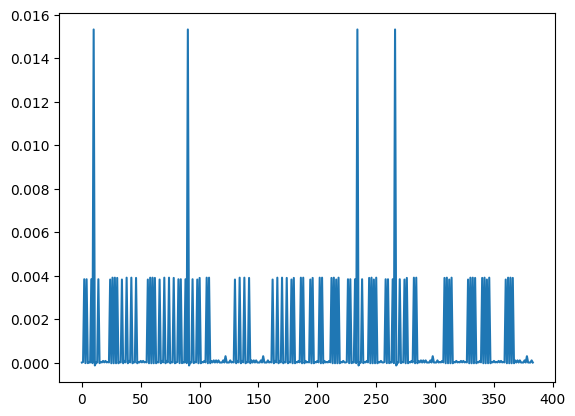

In [395]:
plt.plot(average_correlations[0])

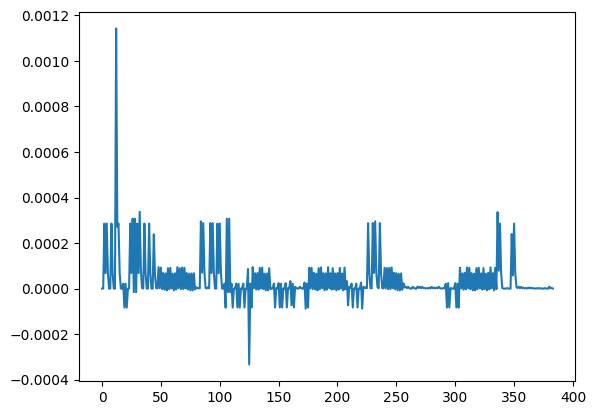

In [396]:
plt.plot(average_correlations[1])